# **MPox Viral Sentiments: BertTopic Master**
#### Capstone Project: Data Science
#### Harvard University, Harvard Extenstion School
#### Spring 2025
#### Thomas Brauch, Ananth Pallipuram Ramachandran, Erin Kendrick Rebholz, Jason Ziqi Zhao

**Version Notes:**
Completed Week of 0311:  
--Code to load data for facebook and meta
--Create reporting by topic for most aligned text samples to topic (df)
--Moved to wsl/linux required package adjustments for sanity checkign
--OpenAI runs on colab or wsl
--Creates version saving for files
--Create logic to save and load models/embedding/dfs so you don't need to reprocess

Completed Week of 0318:  
-- Refactored plots so that they could be saved as jpeg and could be aggregated as pdf (fig v plt/pltly)
-- Created logic to save figures as jpegs
-- Created logic to break down larger subplots into separate graphs for pdf report saving
-- New Graphs: Dynamic Topic Modeling using BERTopic

Completed Week of 0325:  
--Created topic report/summary with key text samples and summaries (report)
--Created samples by topic by year plot
--Folder handling for make directories
--Experimented with VADER sentiment. Didn't produce materially different results, however VADER is better documented
--Run on twitter and meta data from Jason
--Create a visualization of text embeddings and top 15 topics**

Completed Week of 0401:  
-- graph of topics by text length, to assess variation
-- Creation of topic-level summary (key words, sentiment, word clouds, engagement, topics over time), etc.
-- Played with embedding models and Bertopic hyperparameters to improve % samples clustered - english better
-- Source specific summaries and representative posts

Completed Week of 0408:  
-- Documentation of parameter tuning for meta data



#### **BerTopic Reference Materials**

https://bertopic.readthedocs.io/en/latest/index.html

https://github.com/miptgirl/miptgirl_medium/blob/main/bertopic_for_coursera/topic_modelling_coursera.ipynb

https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640/

https://medium.com/@danushidk507/topic-modelling-with-bertopic-249095144555


#### **0. Key Model Settings (Must be adjusted from run to run)**

In [1]:
#select data to load: options
data_load_options = ['multi','gdelt','meta_sample','X_10percent','full_agg','meta_x_sample']
data = data_load_options[5] #<---- Selects data used in model training

#file_name_appendix
file_name_appendix = 'X_meta_sample_400_100' #<----adjust file names used to save or load data and models
### Available file_name_appendix for loading: multi_30, meta_sample_200, gdelt_dtm_30, X10sample_200, meta_x_sample,meta_sample_0406
### Latest meta = 'meta_sample_200_100'
### Latest X_meta = 'X_meta_sample_400_100'

#train vs. load existing (NOTE: TRAIN WITH GPU/HIGH RAM)
train = True  #<----setting to Train to topic model, else it will load a model with appendix above
min_cluster_size = 400 #<---adjust this to set minimum samples required for a new topic
min_samples = 100
Tune_UMAP = False ###Use if you want to tune UMAP to maximize the numbers of clustered samples (requires mutliple runs of Bertopic model so time intensive)
map_embeddings = False #True, when train = False, means regenerates emeddings to create a visualization of doc embeddings and topics.

#Analysis and Reporting Options (NOTE: Regenerate Emebddings WITH GPU/HIGH RAM)
plot_umap_tuning = True
generate_topic_level = True  #True generates topic specific summaries and word clouds, False skips
VADER = True #If False TextBlob will be used instead of VADER
plot_barcharts = False #Include the top word barcharts (somewhat duplicative of VADER sentiment charts)

#If meta, displays meta specific engagement metics
#If from aggregated file, uses the normalized data /engagement metrics
#else = 'none'
engagement_option = ['none','meta','aggregated']
engagement = engagement_option[2] #pick one of options above


In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata

#ERIN
#Path for majority of work:
base_path = "/content/drive/MyDrive/Harvard_colab/Capstone_2025/Code Repositories/data/"  #colab
#base_path = "data/" #local

#Separate path for aggregated data set
master_path = '/content/drive/MyDrive/Harvard_colab/Capstone_2025/Data/Data Aggregation/New_Master_Data_v2_mvnupdate.csv'

#Other Team members:


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **1. Imports**

In [3]:
!pip install TextBlob
!pip install openai
!pip install python-dotenv
!pip install matplotlib
!pip install bertopic
!pip install nbformat==5.10.4
!pip install vaderSentiment
!pip3 install emoji==0.6.0
#!pip install -U kaleido
!pip install --upgrade "kaleido==0.1.*"  #for export of plotly plots
import kaleido

In [4]:
#Utilities
import os
import time
import pathlib
import requests
import math

#General
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import numpy as np
from tqdm import tqdm
from datetime import datetime
import itertools

In [5]:
#Topic Modeling
from bertopic.representation import OpenAI
from bertopic.representation import KeyBERTInspired

from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance

#Clustering and visualization methods
import hdbscan
import umap


#### **OPENAI Connection (Local/Colab)**

In [6]:
#### Imports for OpenAI
import openai
from openai import OpenAI # pip install openai
from dotenv import load_dotenv # pip install python-dotenv
import openai


try: #Try to import the OpenAI API key from local .env file

  #Grab the API key from the .env file
  load_dotenv()
  openai_api_key = os.getenv('OPENAI_API_KEY')

  #Raise an error if not present
  #if openai_api_key is None:
  #    raise ValueError("No API key found. Set the OPENAI_API_KEY environment variable.")

  #Open the open AI client
  openai_client = OpenAI()
  #Set the API key for Ooen AI
  openai.api_key = os.environ['OPENAI_API_KEY']
  openai_query = True

except:  #else try to import from Colab secrets
  from google.colab import userdata
  openai_key = userdata.get('OPEN_AI_KEY')

  # Initialize the OpenAI client
  openai_client = OpenAI(api_key=openai_key)

In [7]:
#Intial Promp for Open AI Test
#"gpt-3.5-turbo"
#'gpt-4'
def query_gpt_3_5(prompt):
  response = openai_client.chat.completions.create(
    model= 'gpt-3.5-turbo',
    messages=[
      {"role": "user", "content": prompt}
    ]
  )
  return response.choices[0].message.content


prompt = "Give an overview of Monkeypox"
prompt_result = query_gpt_3_5(prompt)
print(prompt_result)

Monkeypox is a rare viral disease that is similar to smallpox but milder in nature. It is caused by the monkeypox virus, which is mainly found in Central and West Africa. The disease is usually transmitted to humans from animals, such as rodents and primates, through direct contact with the infected animal's blood, bodily fluids, or lesion.

Symptoms of monkeypox typically include fever, headache, muscle aches, and a rash that often starts on the face and spreads to other parts of the body. The disease is usually self-limiting, meaning that it will resolve on its own without specific treatment. However, in some cases, monkeypox can cause severe illness and even death.

There is currently no specific treatment for monkeypox, but supportive care such as pain relief, hydration, and rest can help manage symptoms. Prevention measures include avoiding contact with infected animals, practicing good hygiene, and getting vaccinated against smallpox if traveling to regions where monkeypox is pre

In [8]:
#Used to check if directory is available for saving images

def create_directory_if_not_exists(dir_path):
    """Checks if a directory exists and creates it if it doesn't.

    Args:
        dir_path: The path to the directory.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Directory '{dir_path}' created.")
    else:
        print(f"Directory '{dir_path}' already exists.")

In [9]:
#Tracking list of figures & names for pdf maker in Section 7
figures = []
fig_names = []

# Checks to make sure there is a figures directory for the loaded model:
fig_path = os.path.join(base_path,f'results/model_{file_name_appendix}/figures/')
create_directory_if_not_exists(fig_path)

Directory '/content/drive/MyDrive/Harvard_colab/Capstone_2025/Code Repositories/data/results/model_X_meta_sample_400_100/figures/' already exists.


### **2. Load Data  (if Training)**

**Load data**

In [10]:
if train == True:
  if data == 'multi':
      #Load Sample Data from Public Health Messages with Pre-Defined Categories
      mpox_df = pd.read_csv(os.path.join(base_path, 'public_messaging/final/mp_ph_df.csv'))

      #Load other data sets to categorize
      gdelt_df = pd.read_csv(os.path.join(base_path, 'gdelt/gdelt_df.csv'))
      red_df = pd.read_csv(os.path.join(base_path, 'reddit/reddit_monkeypox.csv'))
      twitter_df = pd.read_csv(os.path.join(base_path, 'twitter/sample_twitter_posts.csv'),encoding_errors ='ignore' , encoding= 'utf-8')

      #Gdelt column normalization
      new_g = gdelt_df.loc[:,['title_desc','yyyy-mm-dd','lang','SourceCommonName']]
      new_g.columns = ['text','date','lang','content_source']
      new_g['master_source'] = 'gdelt'
      new_g['category'] = ''

      #Public Health Comms Column Normalization
      mpox_df['master_source'] = 'public_health'
      new_p = mpox_df.loc[:,['Sentence','Pub_Date','Language','Source','master_source','Category']]
      new_p.columns = ['text', 'date', 'lang', 'content_source', 'master_source', 'category']

      new_p['date'] = pd.to_datetime(twitter_df['date']).dt.strftime('%Y-%m-%d')

      #Twitter Column Normalization
      twitter_df['master_source'] = 'twitter'
      twitter_df['content_source'] = 'twitter'
      twitter_df['yyyy-mm-dd'] = pd.to_datetime(twitter_df['date']).dt.strftime('%Y-%m-%d')
      new_t = twitter_df.loc[:,['tweet','yyyy-mm-dd','language','content_source','master_source']]

      new_t['category'] = ''
      new_t.columns = ['text','date','lang','content_source','master_source','category']

      #Normalize Reddit
      red_df['date'] = pd.to_datetime(red_df['year-month-day']).dt.strftime('%Y-%m-%d')
      red_df['title_body'] = [str(t) if d == np.nan else str(t) + ': ' + str(d) for t,d in zip(red_df.title,red_df.body)]
      red_df['lang'] = ''
      red_df['master_source'] = 'reddit'
      red_df['category'] = ''

      new_r = red_df.loc[:,['title_body','date','lang','created','master_source','category']]
      new_r.columns = ['text','date','lang','content_source','master_source','category']

      #Combine data sources
      combo_pd = pd.concat([new_g, new_p],axis=0,ignore_index=True)
      combo_pd = pd.concat([combo_pd, new_t],axis=0,ignore_index=True)
      combo_pd = pd.concat([combo_pd, new_r],axis=0,ignore_index=True)

      #Ensure that all text is a string for processing in topic models
      combo_pd.text = combo_pd.text.astype(str)

  elif data == 'gdelt':
      #Load gdelt data
      combo_pd = pd.read_csv(os.path.join(base_path, 'gdelt/gdelt_df.csv'))
      combo_pd = combo_pd.loc[:,['title_desc','yyyy-mm-dd','lang','SourceCommonName']]
      combo_pd.columns = ['text','date','lang','content_source']
      combo_pd['master_source'] = 'gdelt'
      combo_pd['category'] = ''

      #Ensure that all text is a string for processing in topic models
      combo_pd.text = combo_pd.text.astype(str)
      pass

  elif data == 'meta_sample':
      #Load Sample Data from Public Health Messages with Pre-Defined Categories
      combo_pd = pd.read_csv(os.path.join(base_path, 'meta/facebook_mpox_monkeypox_subset_dump.csv'))

      #Ensure that all text is a string for processing in topic models
      combo_pd.text = combo_pd.text.astype(str)
      combo_pd['text'] = [t[:5000] for t in combo_pd.text.astype(str)]

      #change to yyyy-mm-dd format
      combo_pd['date'] = pd.to_datetime(combo_pd.creation_time).dt.strftime('%Y-%m-%d')
      combo_pd['master_source'] = 'meta'
      combo_pd['content_source'] = 'facebook'
      combo_pd['category'] = ''
      pass

  elif data == 'X_10percent':
    #Load data
    combo_pd = pd.read_csv(master_path)

    #Reformat Colums to Meet Standards
    combo_pd['text'] = combo_pd['Master Body Text'].astype(str)
    combo_pd['text'] = [t[:2500] for t in combo_pd.text.astype(str)]
    combo_pd['date'] = pd.to_datetime(combo_pd['Master Date']).dt.strftime('%Y-%m-%d')
    combo_pd['master_source'] = combo_pd['Master Source'].astype(str)
    combo_pd['lang'] = combo_pd['Master Language'].astype(str)

    # Drop rows with invalid or missing timestamps
    timestamps = combo_pd['date'].dropna()
    combo_pd = combo_pd.loc[timestamps.index]

    #preserve index from master data for analysis
    combo_pd['idx'] = combo_pd.index

    #Only X Data
    combo_pd = combo_pd[combo_pd.master_source == 'X']

    #Sample
    frac = 0.1
    random_state = 42
    combo_pd = combo_pd.sample(frac=frac, random_state=random_state).reset_index(drop=True)

    #Ensure that all text is a string for processing in topic models
    combo_pd.text = combo_pd.text.astype(str)
    pass

  elif data == 'full_agg':
    #Load data
    combo_pd = pd.read_csv(master_path)

    #Reformat Colums to Meet Standards
    combo_pd['text'] = combo_pd['Master Body Text'].astype(str)
    combo_pd['text'] = [t[:2500] for t in combo_pd.text.astype(str)]
    combo_pd['date'] = pd.to_datetime(combo_pd['Master Date']).dt.strftime('%Y-%m-%d')
    combo_pd['master_source'] = combo_pd['Master Source'].astype(str)
    combo_pd['lang'] = combo_pd['Master Language'].astype(str)

    # Drop rows with invalid or missing timestamps
    timestamps = combo_pd['date'].dropna()
    combo_pd = combo_pd.loc[timestamps.index]

    #preserve index from master data for analysis
    combo_pd['idx'] = combo_pd.index

    #Ensure that all text is a string for processing in topic models
    combo_pd.text = combo_pd.text.astype(str)
    pass

  elif data == 'meta_x_sample':
    #Load data
    combo_pd = pd.read_csv(master_path)

    #Reformat Colums to Meet Standards
    combo_pd['text'] = combo_pd['Master Body Text'].astype(str)
    combo_pd['text'] = [t[:2500] for t in combo_pd.text.astype(str)]
    combo_pd['date'] = pd.to_datetime(combo_pd['Master Date']).dt.strftime('%Y-%m-%d')
    combo_pd['master_source'] = combo_pd['Master Source'].astype(str)
    combo_pd['lang'] = combo_pd['Master Language'].astype(str)

    # Drop rows with invalid or missing timestamps
    timestamps = combo_pd['date'].dropna()
    combo_pd = combo_pd.loc[timestamps.index]

    #preserve index from master data for analysis
    combo_pd['idx'] = combo_pd.index

    #Only X and Meta Data
    combo_pd = combo_pd[(combo_pd.master_source == 'X')|(combo_pd.master_source == 'Meta') ]

    #Sample
    frac = 0.1
    random_state = 42
    combo_pd = combo_pd.sample(frac=frac, random_state=random_state).reset_index(drop=True)

    #Ensure that all text is a string for processing in topic models
    combo_pd.text = combo_pd.text.astype(str)
    pass



<ipython-input-10-6113fbeb49cd>:132: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  combo_pd = pd.read_csv(master_path)


### **3. TopicBERT: Model and Dataframes**

This version works to create a more reproducible instance of code.   
More of the layers of the code are pre-specified by the model up front

OpenAI summarization is handled through the package vs. with custom code, after the fact.  

Builds on code in the github repo for BerTopic:
https://github.com/MaartenGr/BERTopic/discussions/2244


Standards for BerTopic Package:
https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.__init__

##### **3.1 Function to run Main Topic Model Code**

In [11]:
##topic_model = BERTopic(embedding_model=embedding_model)
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.feature_extraction.text import CountVectorizer

### If Train is False: Load previous model with the file_name_appendix in section 2
if train == False:
    try:
        #embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
        embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
        topic_model_m = BERTopic.load(os.path.join(base_path,f'results/model_{file_name_appendix}'),embedding_model=embedding_model) # Use if you don't want to load embeddings
    except:
         raise ('Please either select train == True, or try a different file_name_appendix')

### Otherwise train the model
else:
    ###Rename text to docs
    docs = combo_pd.text.tolist()

    #Open AI Setup for BerTopic
    response = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",# "gpt-4",
        messages=[{"role": "user", "content": "Hello"}]
        )

    ###Sentence Transformer and Embdedding Model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2") #WORKS-Used for english -- if use this, languages will be grouped in similar topics.
    #embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2") #WORKS: Used for multilingual, allows for better integration of themes across langagues
    embeddings = embedding_model.encode(docs, show_progress_bar=True)  #Pre-run the emeddings and input directly into model

    ### Dimensionality Reduction then Clustering
    umap_model = UMAP(n_neighbors=10, n_components=15, min_dist=0.0, metric='cosine', random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                            metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    ### Vectorizer Commented out, used standard for package cTF-IDF
    vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

    ### Representation Models
    keybert_model = KeyBERTInspired()
    mmr_model = MaximalMarginalRelevance(diversity=0.3)

    prompt = """I have a topic that contains the following documents:
    [DOCUMENTS]
    The topic is described by the following keywords: [KEYWORDS]

    Based on the information above, extract a short but highly descriptive topic label of at most 4 words. Make sure it is in the following format:
    topic: <topic label>
    """

    ###Chose one below, 3.5 is cheaper, 4 has bigger context/more nuanced results
    #openai_model = OpenAI(openai_client, model="gpt-4", exponential_backoff=True, chat=True, prompt=prompt)
    openai_model = OpenAI(openai_client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)  #for cost savings :)

    representation_model = {"KeyBERT": keybert_model, "OpenAI": openai_model, "MMR": mmr_model}

    topic_model_m = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        top_n_words=20,
        verbose=True,
        calculate_probabilities=True,
        language="english"
        )
    if Tune_UMAP == True:
      pass
    else:
      #Run model
      topics_m, probs_m = topic_model_m.fit_transform(docs, embeddings)

      ###  Add assigned topic model back to original dataframe for future use analysis
      combo_pd['topic_num'] = topic_model_m.get_document_info(combo_pd.text).Topic

      ### Save model
      topic_model_m.save(os.path.join(base_path,f'results/model_{file_name_appendix}'), serialization="pytorch",
                         save_ctfidf=True, save_embedding_model=embedding_model)


Batches:   0%|          | 0/4920 [00:00<?, ?it/s]

2025-04-15 18:06:28,158 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-15 18:10:27,260 - BERTopic - Dimensionality - Completed ✓
2025-04-15 18:10:27,270 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-15 18:12:20,184 - BERTopic - Cluster - Completed ✓
2025-04-15 18:12:20,212 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 44/44 [00:27<00:00,  1.62it/s]
2025-04-15 18:12:57,302 - BERTopic - Representation - Completed ✓


#### **3.1.b. Explore BERTopic Tuning Variation (TAKES HOURS)**

In [12]:
#Runs agains a set of hyperparameters for n_comp, n_neighbors, and HDBSCAN min clusters
if Tune_UMAP == True:
  #reset column to date time
  combo_pd['date'] = pd.to_datetime(combo_pd['date'])

  # Create a new column for the custom fiscal year
  combo_pd['analysis_year'] = combo_pd['date'].apply(
      lambda x: x.year if x.month >= 4 else x.year - 1)

  n_comp = [10,15]#[5,10,15]#,20,30]
  n_neighbors =[10,20]#[5,10,50,100]#,30,50,100,200]#[5,10,15]
  cluster_range = [400,200]#[100,150]#[400,200,50]
  min_samples = [400,200,100]

  comps_neighbors = []
  overall_unclustered = []
  unclustered_2022 = []
  unclustered_2023 = []
  unclustered_2024 = []
  topicct = []

  for ms in min_samples:
    for cl in cluster_range:
      for nc in n_comp:
        for nn in n_neighbors:
          #Log parameters
          comps_neighbors.append(f'{cl}_{nc}_{nn}_{ms}')

          #Run model for each setting:
          umap_model = UMAP(n_neighbors=nn, n_components=nc, min_dist=0.0, metric='cosine', random_state=42)
          hdbscan_model = HDBSCAN(min_cluster_size=cl, min_samples=ms, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
          representation_model = {"MMR": mmr_model}#, "KeyBERT": keybert_model, "OpenAI": openai_model}

          #embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2") #WORKS: Used for multilingual, allows for better integration of themes across langagues
          embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

          topic_model_m = BERTopic(
                embedding_model=embedding_model,
                umap_model=umap_model,
                hdbscan_model=hdbscan_model,
                vectorizer_model=vectorizer_model,
                representation_model=representation_model,
                top_n_words=20,
                verbose=True,
                calculate_probabilities=True,
                language="english"
                )
          topics, probs = topic_model_m.fit_transform(docs, embeddings)

          ###  Add assigned topic model back to original dataframe for analysis
          combo_pd['topic_num'] = topic_model_m.get_document_info(combo_pd.text).Topic

          # Key Metrics: % of Overall Unclustered, % Unclustered in 2022, 2023, 2024
          helper = len(combo_pd[combo_pd['topic_num']==-1])/len(combo_pd)
          overall_unclustered.append(helper)

          # Calculate annotations by year
          unclustered_2022.append(len(combo_pd[(combo_pd['analysis_year']==2022)&(combo_pd['topic_num']==-1)])/len(combo_pd[combo_pd['analysis_year']==2022]))
          unclustered_2023.append(len(combo_pd[(combo_pd['analysis_year']==2023)&(combo_pd['topic_num']==-1)])/len(combo_pd[combo_pd['analysis_year']==2023]))
          unclustered_2024.append(len(combo_pd[(combo_pd['analysis_year']==2024)&(combo_pd['topic_num']==-1)])/len(combo_pd[combo_pd['analysis_year']==2024]))

          #log resultant topics
          topic_info = topic_model_m.get_topic_info()
          topicct.append(len(topic_info))

          #Print interim results
          print(f'{cl}_{nc}_{nn}_{ms}_unclustered_{helper}_topics{len(topic_info)}')

          #store in df
          umap_tune = pd.DataFrame({'dimensions':comps_neighbors,'overall_unclustered':overall_unclustered,
                                    'unclustered_2022':unclustered_2022,'unclustered_2023':unclustered_2023,
                                    'unclustered_2024':unclustered_2024,'topics':topicct})

          umap_tune['composite_score'] = (umap_tune.overall_unclustered*2 + umap_tune.unclustered_2022 + umap_tune.unclustered_2023 + umap_tune.unclustered_2024)/5

          umap_tune.to_csv(os.path.join(base_path,f'results/model_{file_name_appendix}/umap_tune_eng.csv'),index=False)

  #plot and save fig
  fig, ax = plt.subplots(figsize=(12,5))
  ax.plot(umap_tune.dimensions,umap_tune.unclustered_2022,marker='o',linestyle = ':',alpha = 0.5,label='2022')
  ax.plot(umap_tune.dimensions,umap_tune.unclustered_2023,marker='o',linestyle = ':',alpha = 0.5,label='2023')
  ax.plot(umap_tune.dimensions,umap_tune.unclustered_2024,marker='o',linestyle = ':',alpha = 0.5,label='2024')
  ax.plot(umap_tune.dimensions,umap_tune.overall_unclustered,marker='o',linestyle = '--',color = 'grey',label='overall')
  ax.plot(umap_tune.dimensions,umap_tune.composite_score,marker='o',linestyle = '-',color = 'k',label='composite')
  ax.set_ylabel('Percentage of Samples Unclustered')
  ax.set_xlabel('UMAP Dimensions_Neighbors Variables')
  ax.legend();

  fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/umap_tuning_eng_{file_name_appendix}.jpeg'),bbox_inches='tight')

  #print best
  best = np.argmin(umap_tune.composite_score)
  print(umap_tune.iloc[best,:])



#### **3.1.c: Visuals for Tuning Results from Specific Model Runs**

Note that this block is only useful if you've run the UMAP tuning above and then, you should annotate selected points that correspond to your final recommend model.

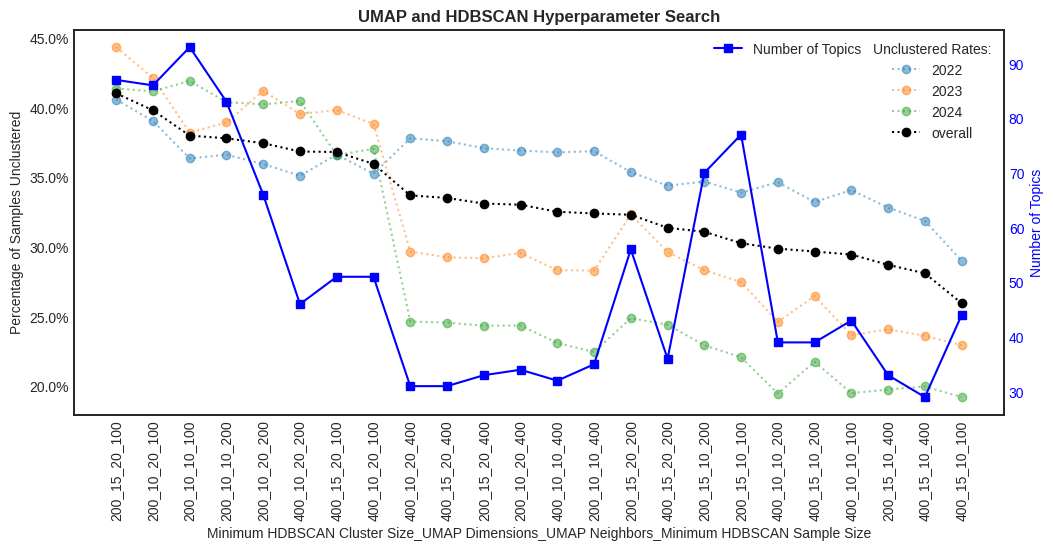

In [13]:
if plot_umap_tuning == True:
  from matplotlib.ticker import PercentFormatter
  #Load data
  umap_tune = pd.read_csv(os.path.join(base_path,f'results/model_X_meta_sample_400_100/umap_tune_eng.csv'))
  umap_tune = umap_tune[:29].sort_values(by='overall_unclustered', ascending=False)

  #primary access plot
  fig, ax = plt.subplots(figsize=(12,5))
  ax.plot(umap_tune.dimensions,umap_tune.unclustered_2022,marker='o',linestyle = ':',alpha = 0.5,label='2022')
  ax.plot(umap_tune.dimensions,umap_tune.unclustered_2023,marker='o',linestyle = ':',alpha = 0.5,label='2023')
  ax.plot(umap_tune.dimensions,umap_tune.unclustered_2024,marker='o',linestyle = ':',alpha = 0.5,label='2024')
  ax.plot(umap_tune.dimensions,umap_tune.overall_unclustered,marker='o',linestyle = ':',color = 'black',label='overall')

  #Label key points for data sets
  if file_name_appendix == 'meta_sample_200_100':
    candidate_labels = ['200_10_10', '400_10_10', '400_10_100', '50_15_10']
  elif file_name_appendix == 'X_meta_sample_400_100':
    candidate_labels = ['200_10_10', '400_10_10', '400_10_100', '50_15_10']
  else:
    pass

  for label in candidate_labels:
    match = umap_tune[umap_tune.dimensions == label]
    if not match.empty:
        y_val = match.overall_unclustered.values[0]
        ax.annotate(f"{y_val:.0%}",
                    xy=(label, y_val),
                    xytext=(-5, 2),  # Shift to the left
                    textcoords='offset points',
                    ha='right',  # Align text to the right of the anchor point
                    va='center',
                    fontsize=8,
                    color='black')

  ax.set_title('UMAP and HDBSCAN Hyperparameter Search', fontweight ='bold')
  ax.yaxis.set_major_formatter(PercentFormatter(1.0))
  ax.set_ylabel('Percentage of Samples Unclustered')
  ax.set_xlabel('Minimum HDBSCAN Cluster Size_UMAP Dimensions_UMAP Neighbors_Minimum HDBSCAN Sample Size')
  plt.xticks(rotation=90)
  legend1 = ax.legend()
  legend1.set_title("Overall Clustering Rates")

  #secondary access plot of number of topics
  ax2 = ax.twinx()
  ax2.plot(umap_tune.dimensions, umap_tune.topics, marker='s', linestyle='-', color='b', label='Number of Topics')
  ax2.set_ylabel('Number of Topics', color='b')
  ax2.tick_params(axis='y', labelcolor='b')

  #Candidate best points:

  if file_name_appendix == 'meta_sample_200_100':
    ax2.axvline('400_10_10', color='grey', linestyle = '--',label = 'candidate 1')
    ax2.axvline('200_10_10', color='grey', linestyle = ':',label = 'candidate 2')
    ax2.axvline('400_10_100', color='red', linestyle = '--',label = 'exclude, too few topics')
    ax2.axvline('50_15_10', color='red', linestyle = ':',label = 'exclude, too many topics')
  if file_name_appendix == 'meta_X_sample_400_100':
    pass
  # Add legends for both axes
  if file_name_appendix == 'meta_sample_200_100':
    ax2.legend(loc='center right')
    legend = ax.legend(loc='lower right')
    legend.set_title("Unclustered Rates:")

  else:
    ax2.legend(bbox_to_anchor=(0.86, 1))
    legend = ax.legend(bbox_to_anchor=(1, 1))
    legend.set_title("Unclustered Rates:")

  #Save and log
  fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/param_tuning_{file_name_appendix}.jpeg'),bbox_inches='tight')
  figures.append(fig)
  fig_names.append(f'param_tuning_{file_name_appendix}')

**Only Useful for Final Meta Model**

In [14]:
if file_name_appendix == 'meta_sample_200_100':
  from matplotlib.ticker import PercentFormatter
  #Load saved data and reset column names
  fine_tune = pd.read_csv(os.path.join(base_path,f'results/model_{file_name_appendix}/hyperparameter_multi_english.csv'))
  col_set = fine_tune.columns
  col_set = ['dimensions', 'overall_unclustered', 'unclustered_2022',
        'unclustered_2023', 'unclustered_2024', 'topics', 'composite_score',
        'lang']
  fine_tune.columns = col_set

  #plotting data for multilingual vs. english embedding model
  multi = fine_tune[fine_tune.lang == 'multilingual']
  english = fine_tune[fine_tune.lang == 'english']

  #Set up 2 subplots
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  ax = axs.flatten()

  #Plot 1 - comparison of overall clustering multi vs. english
  ax[0].plot(english.dimensions,english.overall_unclustered,marker='o',linestyle = '--',label='english')
  ax[0].plot(multi.dimensions,multi.overall_unclustered,marker='o',linestyle = '--',label='multilingual')
  ax[0].axvline('200_10_10_100', color='grey', linestyle = '--',label='candidate_1')
  ax[0].axvline('400_10_10_100', color='grey', linestyle = ':',label='candidate_2')
  legend1 = ax[0].legend()
  legend1.set_title("Overall Clustering Rates")
  ax[0].legend()
  ax[0].set_title('Comparison of English vs. Multilingual \nEmbedding Models', fontweight ='bold')
  ax[0].set_ylabel('Ratio of Samples Unclustered')
  ax[0].set_xlabel('Minimum HDBSCAN Cluster Size_UMAP Dimensions_\nUMAP Neighbors_HDBSCAN Min Samples Variables')
  ax[0].tick_params(axis='x', labelrotation=90)
  ax[0].yaxis.set_major_formatter(PercentFormatter(1.0))

  #Plot 2, double axes with clustering over time and number of topics
  ax[1].plot(english.dimensions,english.unclustered_2022,marker='o',linestyle = ':',alpha = 0.5,label='2022')
  ax[1].plot(english.dimensions,english.unclustered_2023,marker='o',linestyle = ':',alpha = 0.5,label='2023')
  ax[1].plot(english.dimensions,english.unclustered_2024,marker='o',linestyle = ':',alpha = 0.5,label='2024')
  ax[1].plot(english.dimensions,english.overall_unclustered,marker='o',linestyle = ':',color = 'black',label='overall')

  ax[1].set_title('English Embedding Performance Over Time\n and Resultant Number of Topics', fontweight = 'bold')
  ax[1].set_xlabel('Minimum HDBSCAN Cluster Size_UMAP Dimensions_\nUMAP Neighbors_HDBSCAN Min Samples Variables')
  plt.xticks(rotation=90)
  ax[1].yaxis.set_major_formatter(PercentFormatter(1.0))
  legend2 = ax[1].legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
  legend2.set_title("Clustering Rates:")

  # Plot 2, the number of topics on the secondary y-axis
  ax2 = ax[1].twinx()
  ax2.plot(english.dimensions, english.topics, marker='s', linestyle='-', color='b', label='Number of Topics')
  ax2.axvline('200_10_10_100', color='grey', linestyle = '--',label='candidate_1')
  ax2.axvline('400_10_10_100', color='grey', linestyle = ':',label='candidate_2')
  ax2.set_ylabel('Number of Topics', color='b')
  ax2.tick_params(axis='y', labelcolor='b')
  ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))

  fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/fine_tune_{file_name_appendix}.jpeg'),bbox_inches='tight')
  figures.append(fig)
  fig_names.append(f'fine_tune_{file_name_appendix}')



#### **3.2 Function to create clusters by running UMAP against the topics embdeddings**
**Returns topic_info data frame with key data about topics**

In [15]:
def group_topics(topic_model):
    #Imports
    from sklearn.preprocessing import MinMaxScaler
    from bertopic._utils import select_topic_representation
    from umap import UMAP
    import hdbscan

    ##Flattened from Visualized Topics function
    topics = None # : List[int]
    n_words = 10 #: int

    #Get topic frequencies
    freq_df = topic_model.get_topic_freq()
    freq_df = freq_df.loc[freq_df.Topic != -1, :]
    if topics is not None:
        topics = list(topics)
    else:
        topics = sorted(freq_df.Topic.to_list())

    #### Generate df for topic, info, including AI Summaries of Topics
    topic_info = topic_model.get_topic_info()

    # Extract topic words and their frequencies
    topic_list = sorted(topics)
    words = [" | ".join([word[0] for word in topic_model.get_topic(topic)[:n_words]]) for topic in topic_list]
    topic_info['words'] = ""
    topic_info.loc[1:,'words'] = words

    word_freq = []
    for i in range(-1,len(topic_model_m.topic_representations_)-1):
        word_freq.append(topic_model_m.topic_representations_[i][:n_words])

    #word_freq = [topic_model.topic_representations_[topic][:n_words] for topic in topic_list]
    #topic_info['word_freq'] = word_freq

    # AI Summaries for better printing (non-list version)
    ai_summaries = [x[0] for x in topic_info.OpenAI]
    topic_info['AI_Summaries'] = ai_summaries  #for future plotting

    # Transform Embeddings into 2D Using UMAP
    embeddings = UMAP(n_neighbors=2, n_components=2, metric="cosine", random_state=42).fit_transform(topic_model.topic_embeddings_[1:])

    topic_info['umap_dim_1'] = ""
    topic_info['umap_dim_2'] = ""

    #Assign embeddings to dimension 1 forward
    topic_info.loc[1:,'umap_dim_1'] = embeddings[:, 0] #for future plotting
    topic_info.loc[1:,'umap_dim_2'] = embeddings[:, 1] #for future plotting

    ##Cluster related topics using HDBSCAN
    cluster_model = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

    # Fit the model to the data
    cluster_model.fit(topic_info.loc[1:,['umap_dim_1','umap_dim_2']])

    # Get the cluster labels (Note: -1 means noise points)
    topic_info['clusters'] = ""
    topic_info.loc[1:,'clusters'] = cluster_model.labels_
    topic_info.loc[0,'clusters'] = -1  #Assign the unassigned cluster to the first position

    return topic_info


#### **3.3  Function to calculate TextBlob sentiment polarity score for each doc**

In [16]:
def sentiment_func(combo_pd):
    #Calculate VADER Sentiment Scores
    from textblob import TextBlob

    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity

    #Create a function to get the polarity
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity

    def getAnalysis(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'

    #Create two new columns ‘Subjectivity’ & ‘Polarity’
    combo_pd['TextBlob_Subjectivity'] = combo_pd['text'].apply(getSubjectivity)
    combo_pd['TextBlob_Polarity'] = combo_pd['text'].apply(getPolarity)
    combo_pd['TextBlob_Sentiment'] = combo_pd['TextBlob_Polarity'].apply(getAnalysis)

    return combo_pd

#### **3.4 Add VADER Sentiment**

In [17]:
def add_vader(combo_pd):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    #Convert to string
    combo_pd['text'] = combo_pd['text'].astype(str)

    #Calculate polarity
    analyzer = SentimentIntensityAnalyzer()
    combo_pd['vader_polarity'] = [analyzer.polarity_scores(sample)['compound'] for sample in combo_pd.text]

    return combo_pd

#### **3.5 Function to excerpt and summarize text samples for each topic**

In [18]:
## Analyze the most representative samples by topic
def get_sample_summaries(topic_info_m,combo_pd):
    top_post_summary = []
    negative_summary = []
    top_samples = []
    negative_samples = []

    for i,j in enumerate(topic_info_m.Topic):
        #create a top post sampling rate for OpenAI summary
        samples = topic_info_m.loc[i,'Count']
        if samples > 200:
            top_posts_num = 40
        elif samples <100:
            top_posts_num = 20
        else:
            top_posts_num = int(samples*.20)

        #Isolate the text samples wiht the highest probabilities for inclusion in the topic
        top_posts = combo_pd[combo_pd.topic_num==j].sort_values(by='top_prob',ascending = False)[:top_posts_num].text#
        top_posts = [top[:500] for top in top_posts]
        #top_posts = top_posts.to_list()
        top_samples.append(top_posts[:20])

        #Get open_ai summaries:
        prompt = f"Summarize this content in 100 words or less {top_posts[:20]}"
        top_post_summary.append(query_gpt_3_5(prompt))

        #Find negative sentiment posts
        negative_sentiment = combo_pd[(combo_pd.topic_num==j) & (combo_pd.TextBlob_Sentiment=='Negative')]

        #Check to see how many negative posts are available and adjust top_post_num
        if top_posts_num >= len(negative_sentiment):
            top_posts_num = len(negative_sentiment)
        if top_posts_num <=2:
            negative_samples.append('NaN')
            negative_summary.append('NaN')
        else:
            negative_sentiment = negative_sentiment.sort_values(by='top_prob', ascending = False)[:top_posts_num].text.to_list()
            negative_samples.append(negative_sentiment[:10])

            prompt = f"Summarize this content in 50 words or less {negative_sentiment[:10]}"
            negative_summary.append(query_gpt_3_5(prompt))

    topic_info_m['top_post_summary'] = top_post_summary
    topic_info_m['top_samples']=  top_samples
    topic_info_m['negative_summary'] = negative_summary
    topic_info_m['negative_samples']= negative_samples

    return topic_info_m


#### **3.6. Execute Fungtions 3.2-3.5 and then Save models/data_frames for future use**
https://maartengr.github.io/BERTopic/getting_started/serialization/serialization.html#saving

**Save key dataframes and model if Training, else load model and files from pevious versions**

In [19]:
if train == True:
    #Group topics into clusters and create a topic_info dataframe to log data at the topic level
    topic_info_m = group_topics(topic_model_m)

    #Append the probabilities of the assigned Topic back to the text samples in the text document df:
    combo_pd['top_prob'] = [np.max(n) for n in topic_model_m.probabilities_]  #The highest probability of the assigned topic

    #Add textblob and VADER sentiment columns
    combo_pd = sentiment_func(combo_pd)
    combo_pd = add_vader(combo_pd)

    #Generate sample document summarries for each topic and append to topic_info dataframe
    topic_info_m = get_sample_summaries(topic_info_m, combo_pd)

    ### Assign clusters to text document df
    topic2cluster = dict(zip(topic_info_m.Topic, topic_info_m.clusters))
    combo_pd['cluster'] = combo_pd.topic_num.map(topic2cluster)


    # Checks to make sure there is a data directory for the loaded model:
    fig_path = os.path.join(base_path,f'results/model_{file_name_appendix}/data/')
    create_directory_if_not_exists(fig_path)

    ### Output Text Samples and Topic Data Frames to Csv for future reference
    topic_info_m.to_csv(os.path.join(base_path,f'results/model_{file_name_appendix}/data/topic_info_{file_name_appendix}.csv'),
                        encoding = 'utf-8-sig',index=False)
    combo_pd.to_csv(os.path.join(base_path, f'results/model_{file_name_appendix}/data/combo_pd_{file_name_appendix}.csv'),
                    encoding = 'utf-8-sig',index=False)

else:
    #Load previous versions of the dataframes
    topic_info_m = pd.read_csv(os.path.join(base_path,f'results/model_{file_name_appendix}/data/topic_info_{file_name_appendix}.csv'))
    combo_pd = pd.read_csv(os.path.join(base_path, f'results/model_{file_name_appendix}/data/combo_pd_{file_name_appendix}.csv'))

    ###Rename text to docs
    docs = combo_pd.text.tolist()



Directory '/content/drive/MyDrive/Harvard_colab/Capstone_2025/Code Repositories/data/results/model_X_meta_sample_400_100/data/' already exists.


#### **3.7 Optional embedding topics visualization**

In [20]:
#Maps embeddings of documents to Top 15 Topics
#https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_documents.py
from typing import List, Union
#If in training mode embeddings model will be available
if train == True:
  topic_range = np.arange(0,15,1)
  title = "UMAP 2D Plot of Document Embeddings: Top 15 HDBSCAN Clusters Highlighted"
  custom_labels = [f"{top}:{ai}" for top,ai in zip(topic_info_m.loc[:, "Topic"],topic_info_m.loc[:, "AI_Summaries"])]
  custom_labels = Union[True,custom_labels[1:16]]

  # Reduce dimensionality of embeddings:
  reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
  fig = topic_model_m.visualize_documents(docs, reduced_embeddings=reduced_embeddings,topics = topic_range, title=title, custom_labels = custom_labels)

  # Save/display
  fig.show()
  fig.write_image(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/embedding_{file_name_appendix}.png'))

#Regenerate embeddings if you are in Train = False, and map_embeddings = True
elif map_embeddings == True:
  embeddings = embedding_model.encode(docs, show_progress_bar=True)
  topic_range = np.arange(0,15,1)
  title = "UMAP 2D Plot of Document Embeddings: Top 15 HDBSCAN Clusters Highlighted"

  # Reduce dimensionality of embeddings:
  reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
  fig = topic_model_m.visualize_documents(docs, reduced_embeddings=reduced_embeddings,topics = topic_range, title=title)

  # Save/display
  fig.show()
  fig.write_image(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/embedding_{file_name_appendix}.png'))

#If option to map_embeddings is False in controls and you don't want to map embeddings
else:
  pass

Output hidden; open in https://colab.research.google.com to view.

**Pull up picture of embeddings and added it to the pdf output lists**

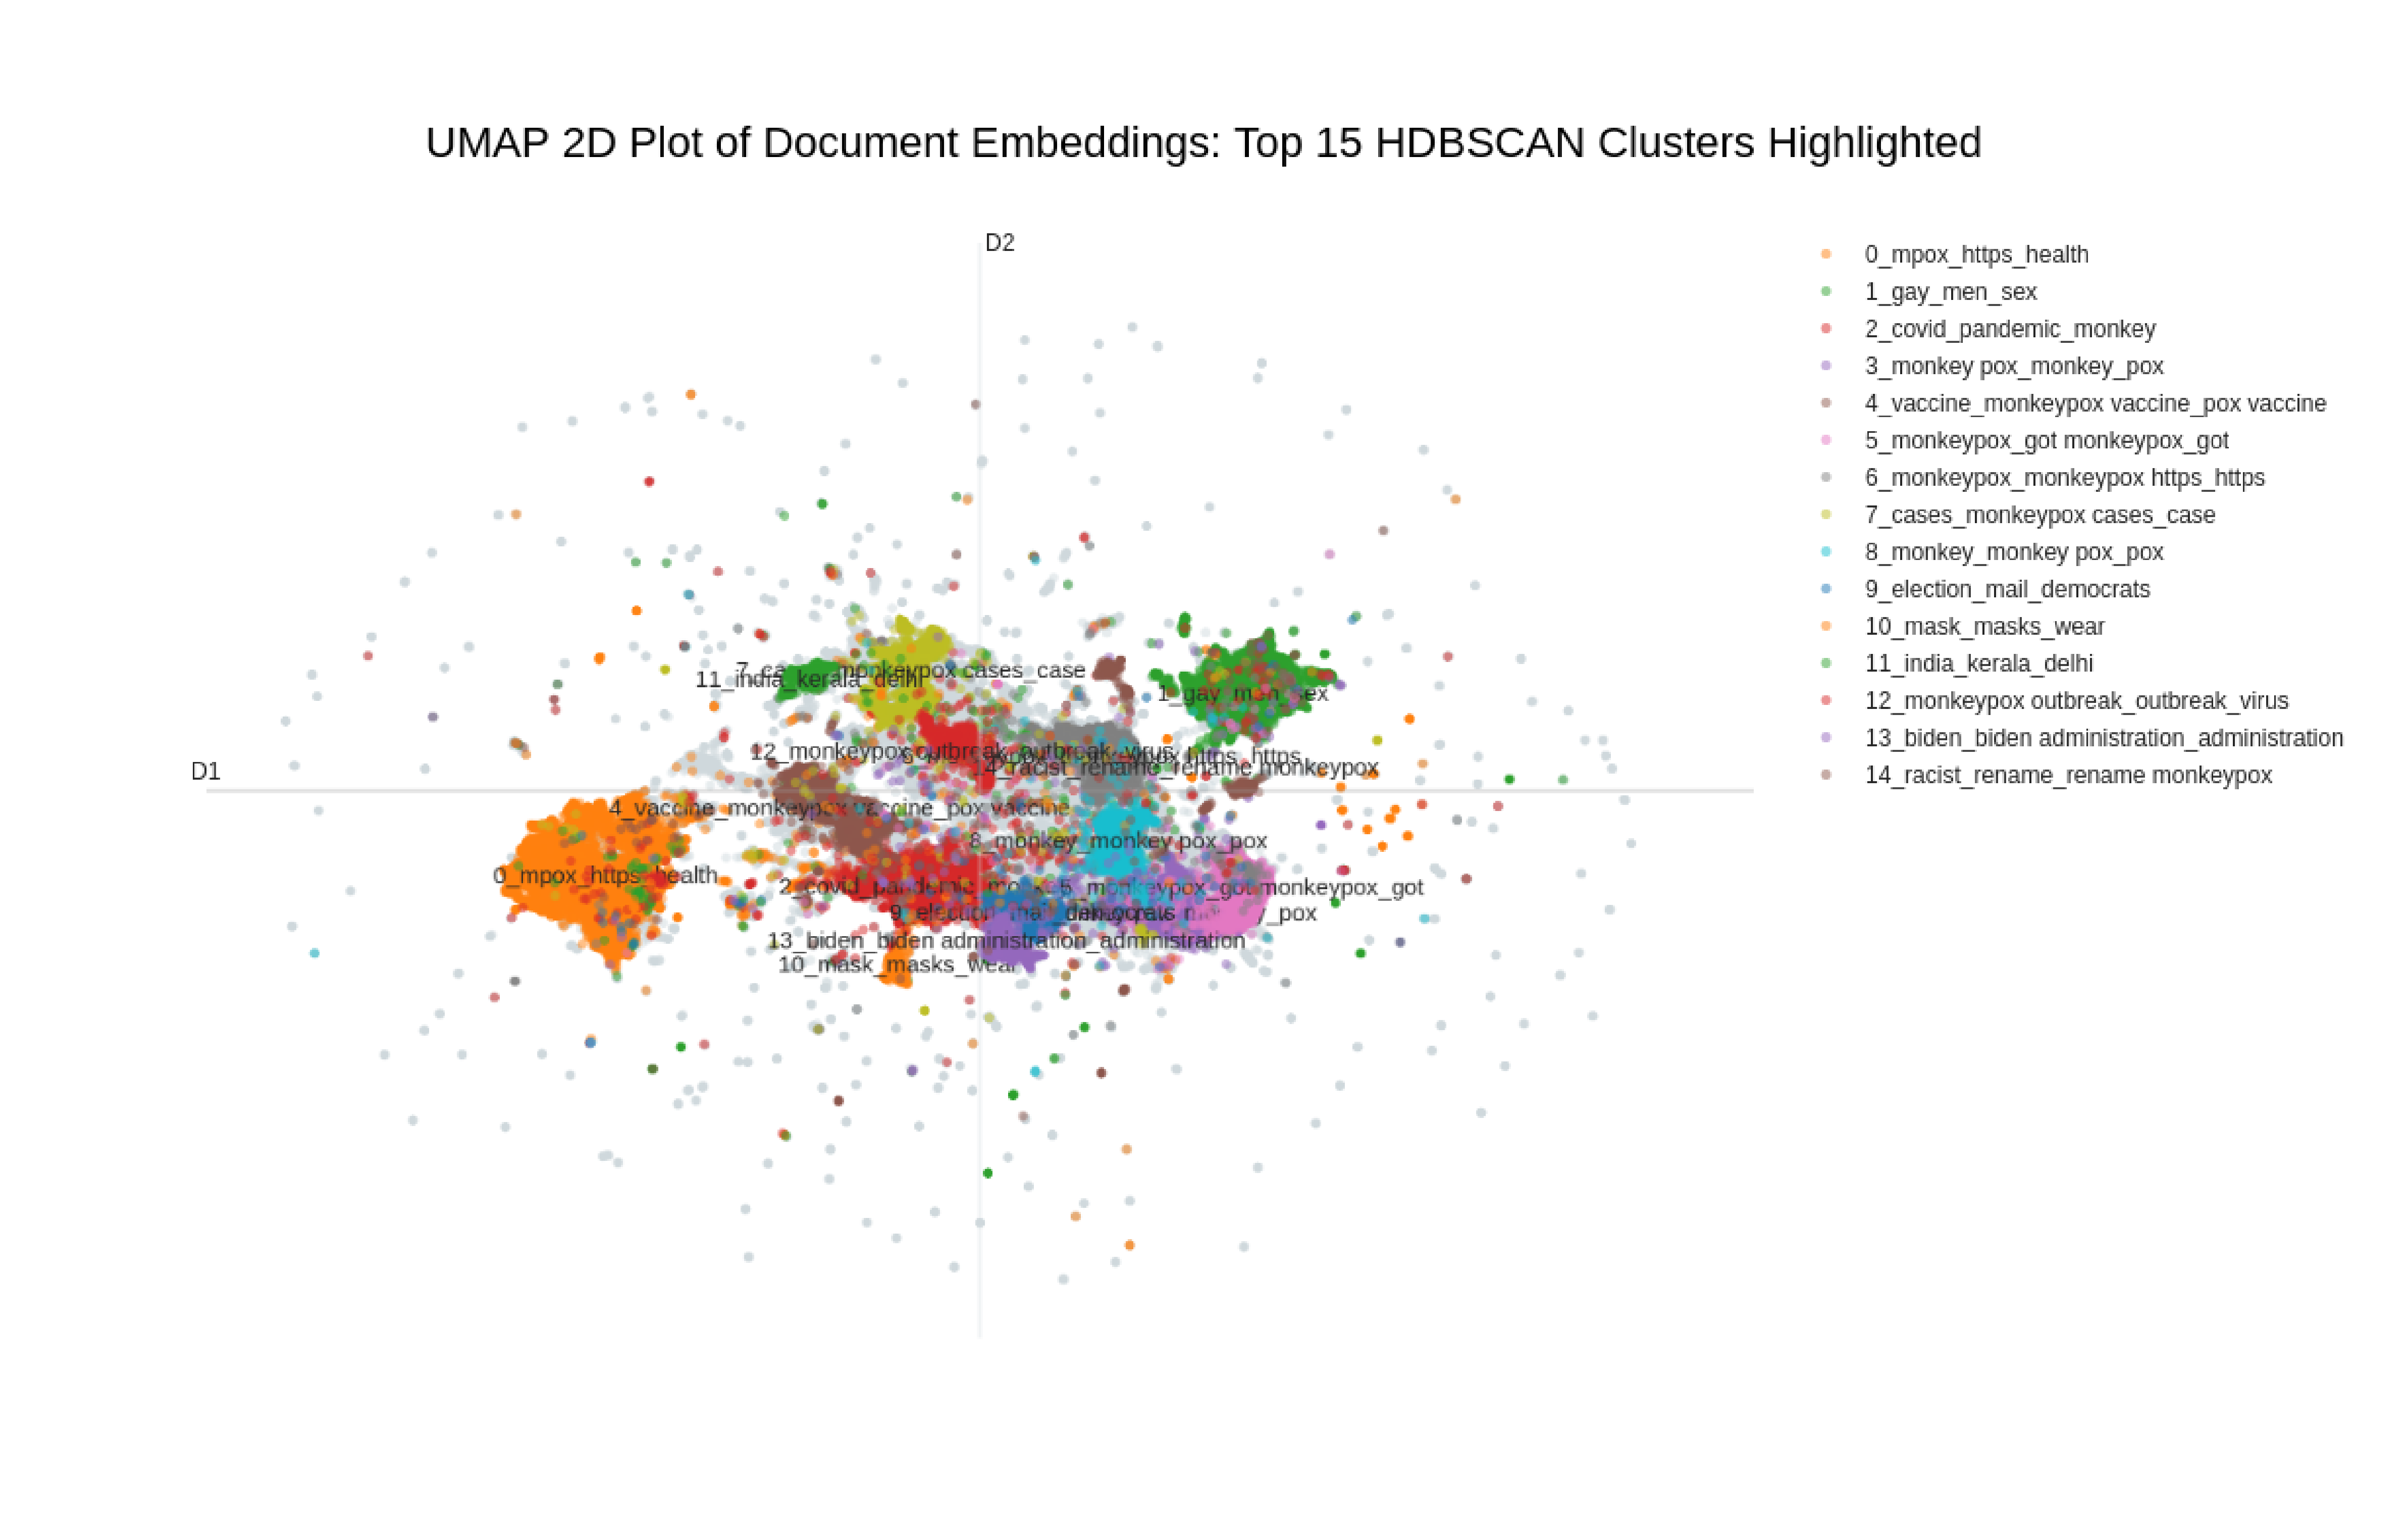

In [21]:
import matplotlib.image as mpimg
# Load the image
image = mpimg.imread(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/embedding_{file_name_appendix}.png'))  # Replace with your actual file path

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10), dpi=600)
# Display the image
ax.imshow(image, interpolation = None)

ax.axis('off')  # Hide axes for a cleaner display
# Show the figure
fig.show()

#Save image to tracker for pdf
figures.append(fig)
fig_names.append('embedding_{file_name_appendix}')

### **4. BERTopic Custom Visuals: Topic and Cluster KPIs**

##### **4a. Samples by Topic**

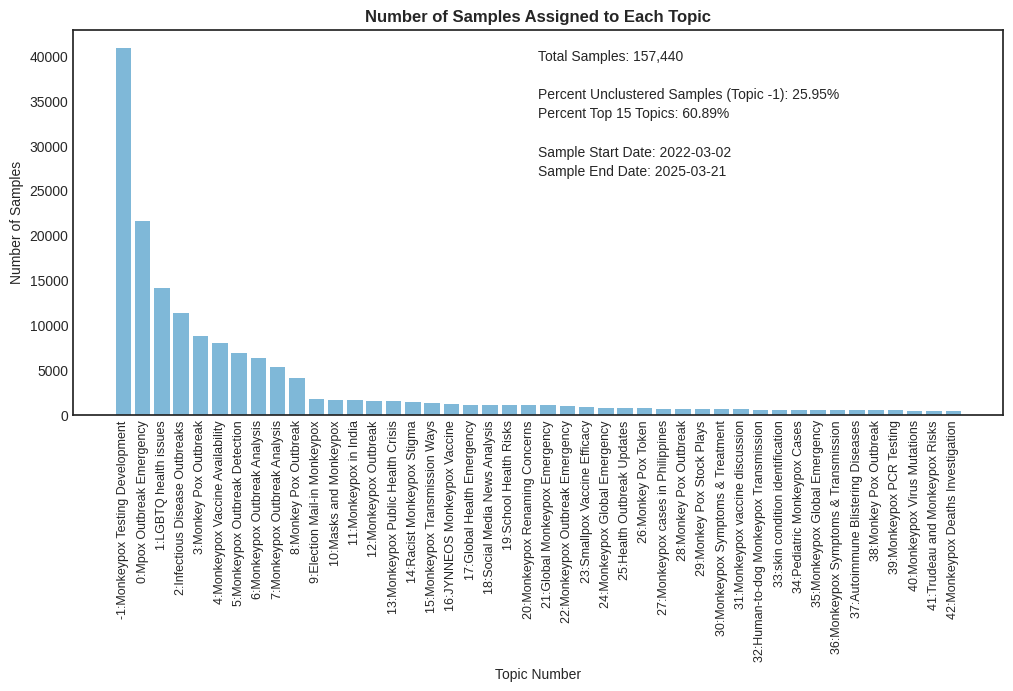

In [22]:
top15ct = len(combo_pd[(combo_pd['topic_num']<15)&(combo_pd['topic_num']>=0)])

#Calc total samples assigned to each topic
topic_cts = combo_pd.pivot_table(index = 'topic_num',values='text', aggfunc=len)

#For annotations
total_samples = f"{int(len(combo_pd)):,}"
dates = pd.to_datetime(combo_pd['date'])
min_date = dates.min().strftime('%Y-%m-%d')
max_date =  dates.max().strftime('%Y-%m-%d')
unclustered_rat = f"{len(combo_pd[combo_pd['topic_num']==-1])/len(combo_pd):.2%}"
top15ct = len(combo_pd[(combo_pd['topic_num']<15)&(combo_pd['topic_num']>=0)])
top_15_ratio = f"{top15ct/len(combo_pd):.2%}"

#Plot of samples assigned to topics
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title('Number of Samples Assigned to Each Topic',fontweight= 'bold')

ax.bar(topic_cts.index,topic_cts.text,color='#0072B2', alpha=0.5)
ax.annotate(f'Total Samples: {total_samples}', xy=(0.5, 0.95), xycoords='axes fraction', ha='left', va='top')
ax.annotate(f'Percent Unclustered Samples (Topic -1): {unclustered_rat}', xy=(0.5, 0.85), xycoords='axes fraction', ha='left', va='top')
ax.annotate(f'Percent Top 15 Topics: {top_15_ratio}', xy=(0.5, 0.80), xycoords='axes fraction', ha='left', va='top')
ax.annotate(f'Sample Start Date: {min_date}', xy=(0.5, 0.70), xycoords='axes fraction', ha='left', va='top')
ax.annotate(f'Sample End Date: {max_date}', xy=(0.5, 0.65), xycoords='axes fraction', ha='left', va='top')

ax.set_xlabel('Topic Number')
ax.set_ylabel('Number of Samples')

# Set xticks to display all labels with names of topics
topic_labels = [f"{top}:{ai}" for top,ai in zip(topic_info_m.loc[:, "Topic"],topic_info_m.loc[:, "AI_Summaries"])]
#ax.set_xticks(range(len(topic_info_m.loc[:, "AI_Summaries"]))
ax.set_xticks(topic_cts.index)
ax.set_xticklabels(topic_labels, rotation=90, ha='center', fontsize=9)  # Rotate x-axis labels for readability;

#exports to jpeg and for pdf in section 7
fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/samples_per_topic_{file_name_appendix}.jpeg'),bbox_inches='tight')
figures.append(fig)
fig_names.append('samples_per_topic_{file_name_appendix}')

**Samples by Analysis Year**

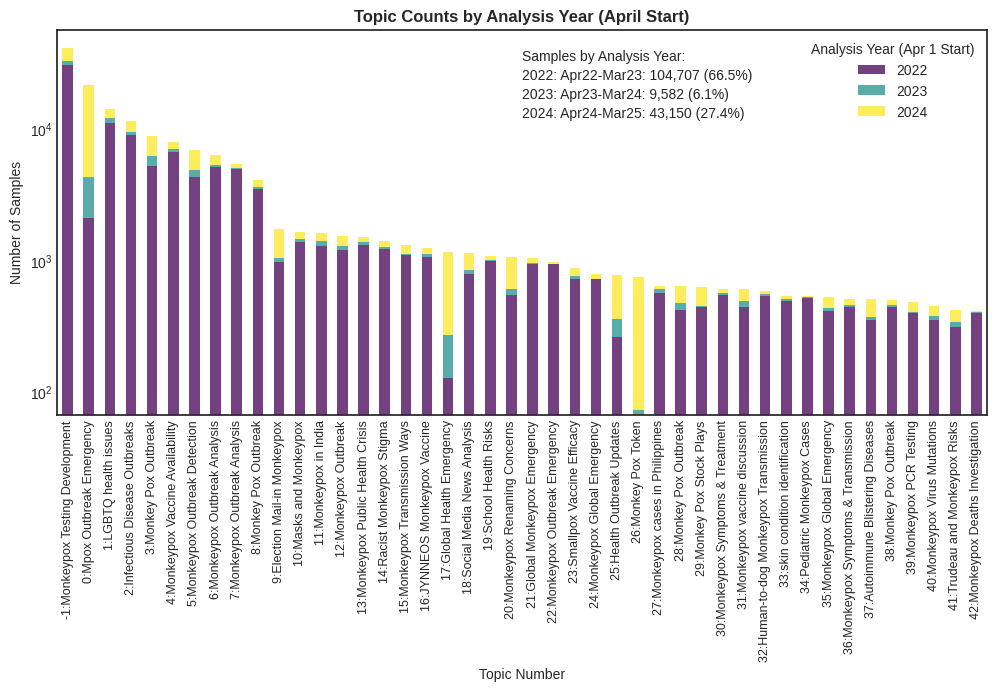

In [23]:
### PREP ###
ai_labels = True

#reset column to date time
combo_pd['date'] = pd.to_datetime(combo_pd['date'])

# Create a new column for the custom fiscal year
combo_pd['analysis_year'] = combo_pd['date'].apply(
    lambda x: x.year if x.month >= 4 else x.year - 1)

# Calculate annotations
samples_2022 = len(combo_pd[combo_pd['analysis_year']==2022])
samples_2023 = len(combo_pd[combo_pd['analysis_year']==2023])
samples_2024 = len(combo_pd[combo_pd['analysis_year']==2024])
samples_2022_rat = f"{samples_2022/len(combo_pd):.1%}"
samples_2023_rat = f"{samples_2023/len(combo_pd):.1%}"
samples_2024_rat = f"{samples_2024/len(combo_pd):.1%}"

#Create pivot by year
pivot = combo_pd.pivot_table(index='topic_num', columns='analysis_year', values='text', aggfunc='count')
pivot_filtered = pivot.drop(columns=2021, errors='ignore')  #removed single 2021 record

### Plot ###
# Set figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the pivot table as a stacked bar chart
pivot_filtered.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', alpha=0.75)

# Customize the plot
ax.set_title("Topic Counts by Analysis Year (April Start)", fontweight='bold')
ax.set_xlabel("Topic Number")
ax.set_ylabel("Number of Samples")
ax.legend(title="Analysis Year (Apr 1 Start)")
ax.tick_params(axis='x', rotation=90)  # Keeps topic numbers readable
ax.set_yscale('log')
ax.annotate(f'Samples by Analysis Year:', xy=(0.5, 0.95), xycoords='axes fraction', ha='left', va='top')
ax.annotate(f'2022: Apr22-Mar23: {samples_2022:,} ({samples_2022_rat})', xy=(0.5, 0.90), xycoords='axes fraction', ha='left', va='top')
ax.annotate(f'2023: Apr23-Mar24: {samples_2023:,} ({samples_2023_rat})', xy=(0.5, 0.85), xycoords='axes fraction', ha='left', va='top')
ax.annotate(f'2024: Apr24-Mar25: {samples_2024:,} ({samples_2024_rat})', xy=(0.5, 0.80), xycoords='axes fraction', ha='left', va='top')


if ai_labels == True:
    topic_labels = [f"{top}:{ai}" for top,ai in zip(topic_info_m.loc[:, "Topic"],topic_info_m.loc[:, "AI_Summaries"])]

    # Set xticks to display all labels
    ax.set_xticks(range(len(topic_info_m.loc[:, "AI_Summaries"])))
    ax.set_xticklabels(topic_labels, rotation=90, ha='center', va='top',fontsize=9);  # Rotate x-axis labels for readability


# Show the plot
plt.show();

#exports to jpeg and for pdf in section 7
fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/samples_year_topic_{file_name_appendix}.jpeg'),bbox_inches='tight')
figures.append(fig)
fig_names.append('samples_year_topic_{file_name_appendix}')

##### **4b. Aggregating Topics into Similar Clusters**

**Standard Code to Visualize Topics based on similarity between topics ((UMAP/HDBSCAN CLUSTERING))**
https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_topics.py

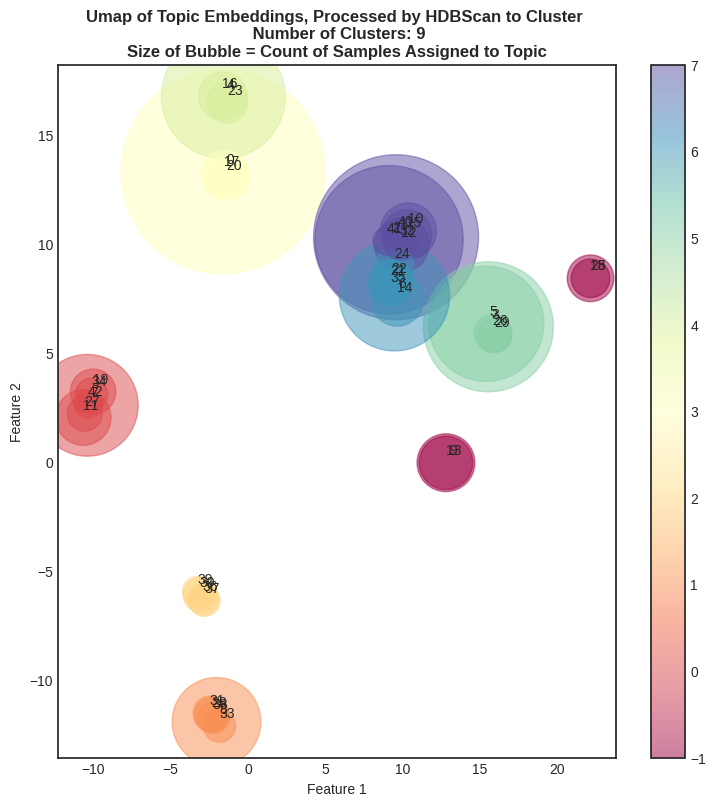

In [24]:
### UMAP / HDBSCAN Clustering of Topics
def topic_cluster_plot(df,title):
    """
    df = Dataframe with the following columns:
        "umap_dim_1": First dimension of Umap of BerTopic Embeddings
        "umap_dim_2": Second dimension of Umap of BerTopic Embeddings
        "Topic": topic_list (Integers)
        "Words": set of topic 10 words in Topic (String)
        "Count": Count of samples assigned to each Topic by BerTopic model (Integer),
    title = Title of the plot
    """
    # Plot the results
    fig, ax = plt.subplots(figsize=(9, 9))
    sc = ax.scatter(df.umap_dim_1, df.umap_dim_2, c=df.clusters, s=df.Count, cmap='Spectral', alpha = 0.5)
    fig.colorbar(sc, ax=ax)  # Use fig.colorbar, not ax.colorbar
    for i, txt in enumerate(df.Topic):
        ax.annotate(txt, (df.umap_dim_1[i]+.2, df.umap_dim_2[i]+.2), textcoords="offset points", xytext=(3,3), ha='center')

    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    return fig, ax

# Plot clustered topics
n_clusters = len(set(topic_info_m['clusters']))
title = f'Umap of Topic Embeddings, Processed by HDBScan to Cluster \n Number of Clusters: {n_clusters}\nSize of Bubble = Count of Samples Assigned to Topic'
fig, ax = topic_cluster_plot(topic_info_m.loc[1:,:].reset_index(),title) #Omits the first row of the topic_info is the samples that weren't assigned topics

#exports to jpeg and for pdf in section 7
figures.append(fig)
fig_names.append('umap_overall_{file_name_appendix}')
fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/umap_overall_{file_name_appendix}.jpeg'),bbox_inches='tight')



##### **4c. Cluster Specifc UMAP Plots**

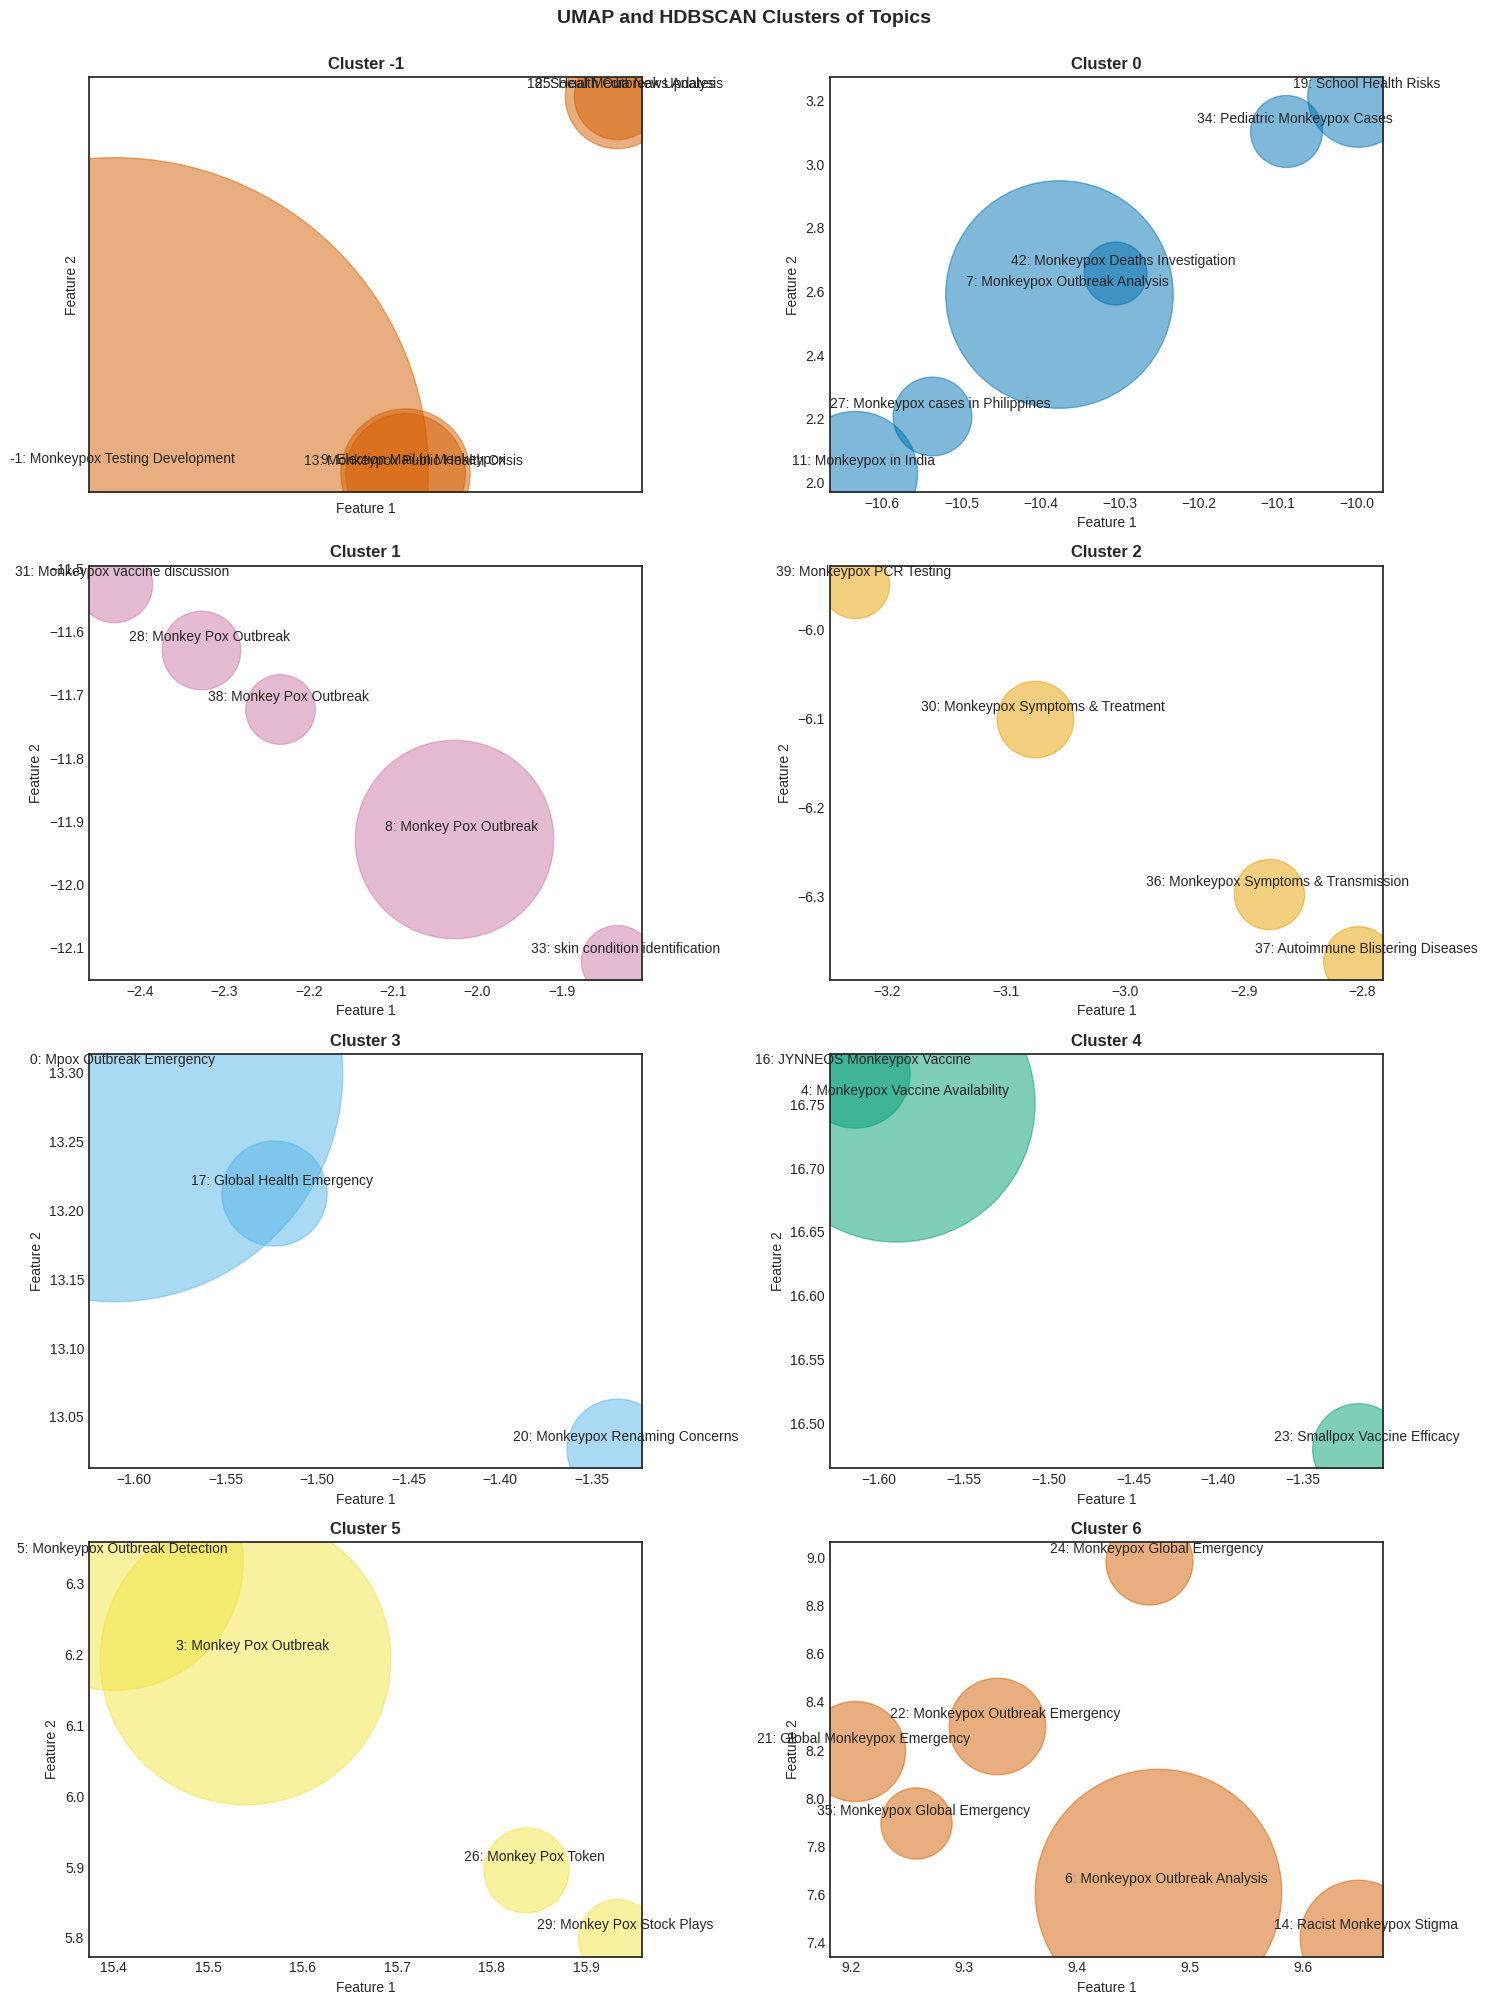

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import os

def topic_cluster_topic_plot(topic_info, file_name_appendix, base_path,figures, fig_names):
    def subplot(df, title, ax, color):
        """
        df = Dataframe with the following columns:
            "umap_dim_1": First dimension of UMAP of BerTopic Embeddings
            "umap_dim_2": Second dimension of UMAP of BerTopic Embeddings
            "Topic": topic list (Integers)
            "AI_Summaries": set of topic summaries
            "Count": Count of samples assigned to each Topic by BerTopic model (Integer)
        title = Title of the plot
        ax = Current subplot axis
        color = Color for the scatter plot
        """
        for j, (txt, summary) in enumerate(zip(df.Topic, df.AI_Summaries)):
            ax.scatter(df.umap_dim_1[j], df.umap_dim_2[j], s=df.Count[j] * 5, c=color, alpha=0.5)
            ax.annotate(f'{txt}: {summary}', (df.umap_dim_1[j], df.umap_dim_2[j]), textcoords="offset points", xytext=(6,6), ha='center')
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    n_clusters = max(topic_info['clusters']) + 1
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])

    for batch_start in range(-1, n_clusters-1, 8):
        batch_end = min(batch_start + 8, n_clusters)
        n_plots = batch_end - batch_start  # Number of actual subplots needed
        n_rows = (n_plots + 1) // 2  # Ensure appropriate row count
        fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5* n_rows))  # Dynamically set rows
        ax = axes.flatten()

        for j, cluster_id in enumerate(range(batch_start, batch_end)):
            c = next(colors)
            cluster_sample = topic_info[topic_info.clusters == cluster_id].reset_index(drop=True)
            title = f'Cluster {cluster_id}'
            subplot(cluster_sample, title, ax[j], c)

                # Turn off unused axes
        for k in range(n_plots, len(ax)):
            ax[k].axis("off")

        plt.suptitle('UMAP and HDBSCAN Clusters of Topics',fontsize=14,fontweight='bold',y=1.0)
        plt.tight_layout()
        plt.show()

        # Save each figure
        count = batch_start // 8 + 1
        fig_name = f'cluster2topic_{count}_{file_name_appendix}'
        fig.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/{fig_name}.jpeg'), bbox_inches='tight')
        figures.append(fig)
        fig_names.append(fig_name)

    return figures, fig_names

figures, fig_names = topic_cluster_topic_plot(topic_info_m, file_name_appendix, base_path, figures, fig_names)

##### **4d. Topics over Time**

**Matplotlib Code for Dynamic Topic Modeling**
linestyle 101:
https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html

In [26]:
## Generates the topic_over_time from the topic_model object
docs = combo_pd.text.astype(str)

# Convert timestamps to datetime objects before passing to topics_over_time
timestamps = pd.to_datetime(combo_pd.date.dt.strftime('%Y-%m-%d')).to_list()

### Generate Data in Roughly Quarterly Bins:
nr_bins = 12
topics_over_time = topic_model_m.topics_over_time(docs, timestamps, nr_bins=nr_bins, global_tuning=False)

12it [00:14,  1.19s/it]


In [27]:
### Generate Data in Roughly Annual Bins:
nr_bins_ar = 3
topics_by_analysis_yr = topic_model_m.topics_over_time(docs, timestamps, nr_bins=nr_bins_ar, global_tuning=False)

3it [00:07,  2.35s/it]


In [28]:
topics_over_time

Topic                                              Words  Frequency  \
0       -1             monkeypox, cases, health, virus, https       1011   
1        0  https newsdiaryonline, newsdiaryonline, newsdi...         15   
2        1                       gay, men, sexual, sex, raves        211   
3        2               pandemic, covid, covid 19, 19, world        212   
4        3          monkey, monkey pox, pox, love, got monkey         80   
..     ...                                                ...        ...   
496     31                 don need, need, vax, pox vax, mzee          3   
497     32  france suspected, monkeypox france, prompt, do...          1   
498     35  dismissing monkeypox, dismissing, drloupis, mo...          1   
499     36  inguinal, myalgia fatigue, face spread, neetpg...          1   
500     41  covid crap, pushing monkey, vaccinated covid, ...          1   

              Timestamp  
0   2022-02-28 21:14:24  
1   2022-02-28 21:14:24  
2   2022-02-28 21:14:24  
3   2022-02-28 21:14:24  
4   2022-02-28 21:14:24  
..                  ...  
496 2024-12-18 02:00:00  
497 2024-12-18 02:00:00  
498 2024-12-18 02:00:00  
499 2024-12-18 02:00:00  
500 2024-12-18 02:00:00  

[501 rows x 4 columns]

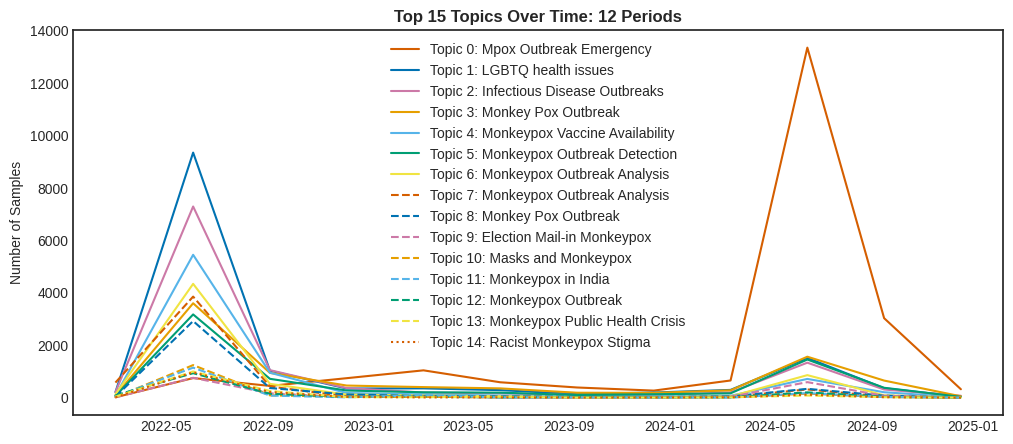

In [29]:
def dtm(topics_over_time,topic_info,topic_range,nr_bins):

    """
    Inputs:
    topics_over_time = a dataframe that is an output of the topics_over_time function from BERTopic topic_model
    topic_info = a topic level dataframe that is returned an output of the topic_model.info function
    topic_range = a range of topic numbers that will be used to generate the graphs,
            To pass a range of all topics:
            topic_range = np.arange(-1,len(set(topic_info['Topic']))-1)
    nr_bins = number of bins variable that was passed to the topics_over_time function for the topic_model.

    Output:
    A single fig with the topics specified
    """

    fig, ax = plt.subplots(figsize=(12,5))
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])
    style = -1
    linestyles = ['-','--',':']

    topic2name = dict(zip(topic_info.Topic,topic_info.AI_Summaries))
    topic_names = [topic2name[t] for t in topic_range]

    for t in topic_range:
        if t%7==0:
            style=style+1

        label = f'Topic {t}: {topic_names[t]}'
        sample = topics_over_time[topics_over_time.Topic == t]
        ax.plot(sample.Timestamp,sample.Frequency, label = label,c=next(colors),linestyle = linestyles[style])
        ax.set_title(f'Top 15 Topics Over Time: {nr_bins} Periods',fontsize=12,fontweight = 'bold')
        ax.set_ylabel('Number of Samples')

        plt.legend()

    return fig

#Range of topics inputted to dtm graphing function
topic_range = list(np.arange(0,15,1))
fig = dtm(topics_over_time, topic_info_m,topic_range,nr_bins)

#Save|catalogue results of function:
figures.append(fig)
fig_names.append('topics_over_time_{file_name_appendix}')
fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/topics_over_time_{file_name_appendix}.jpeg'),bbox_inches='tight')

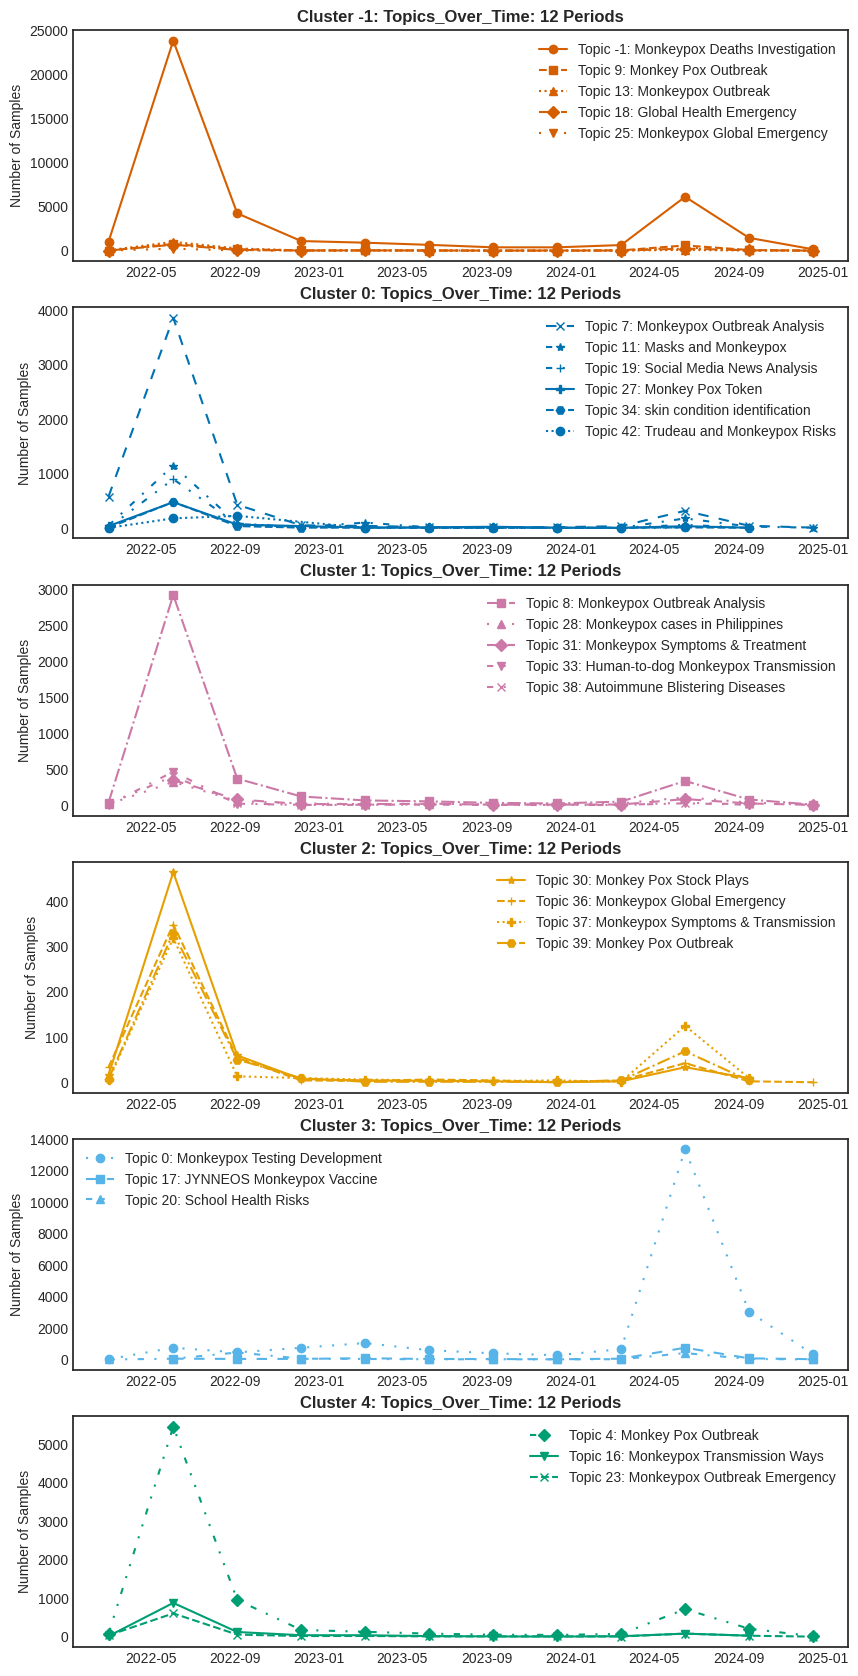

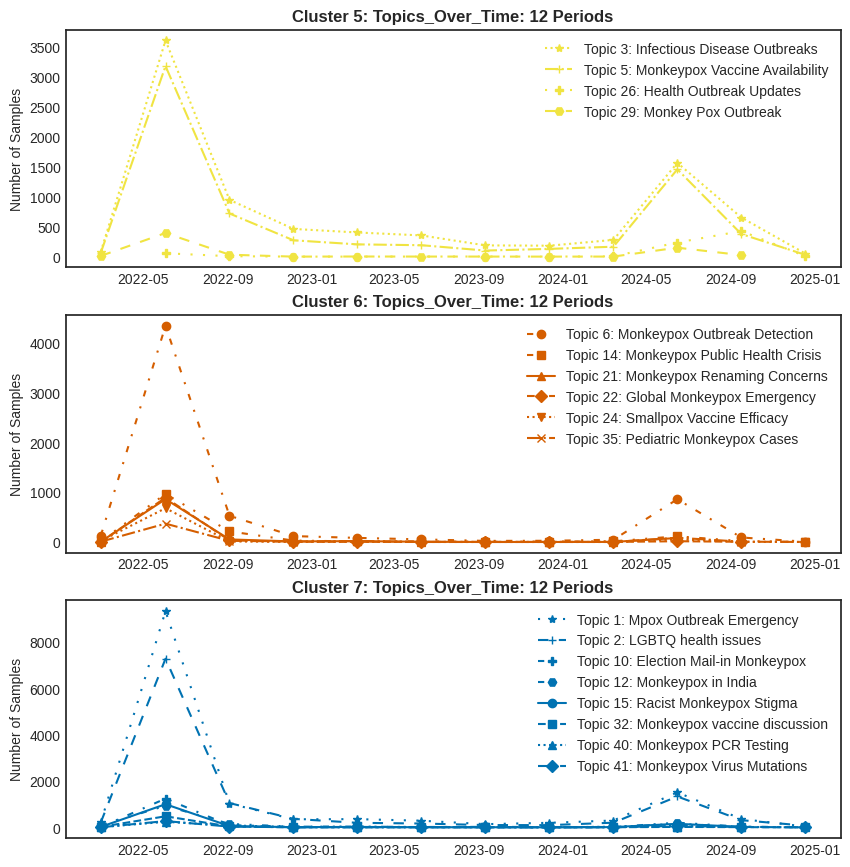

In [30]:
def dtm_cluster(topics_over_time, topic_info, topic_range, nr_bins, file_name_appendix, base_path, figures, fig_names, batch_size=6):
    cluster_range = np.arange(-1, len(set(topic_info['clusters'])) - 1)
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])
    linestyle = itertools.cycle(['solid', 'dashed', 'dotted', 'dashdot', (0, (1, 5)), (0, (5, 5)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5, 1, 5))])
    markers = itertools.cycle(['o', 's', '^', 'D', 'v', 'x', '*', '+', 'P', 'H'])
    topic2name = dict(zip(topic_info.Topic,topic_info.AI_Summaries))
    topic_names = [topic2name[t] for t in topic_range]


    # Loop through the clusters in batches of 'batch_size'
    for batch_start in range(0, len(cluster_range), batch_size):
        batch_end = min(batch_start + batch_size, len(cluster_range))

        fig, ax = plt.subplots(batch_end - batch_start, 1, figsize=(10, (batch_end - batch_start) * 3.5))
        ax = ax.flatten() if len(ax) > 1 else [ax]

        for i, cluster in enumerate(cluster_range[batch_start:batch_end]):
            topic_range = topic_info[topic_info.clusters == cluster].Topic.to_list()
            c = next(colors)

            for t in topic_range:
                #topic_name = topic2name[t].strip("[']")
                label = f'Topic {t}: {topic_names[t]}'
                sample = topics_over_time[topics_over_time.Topic == t]
                l = next(linestyle)
                m = next(markers)
                ax[i].plot(sample.Timestamp, sample.Frequency, label=label, c=c, marker=m,linestyle=l)

            ax[i].set_title(f'Cluster {cluster}: Topics_Over_Time: {nr_bins} Periods', fontsize=12, fontweight='bold')
            ax[i].set_ylabel('Number of Samples')
            ax[i].legend()

        # Save figure for the current batch
        fig_name = f'topics_over_time_clustered_batch_{batch_start // batch_size + 1}_{file_name_appendix}'
        fig.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/{fig_name}.jpeg'), bbox_inches='tight')

        # Append the figure to the list of figures
        figures.append(fig)
        fig_names.append(fig_name)

    return figures, fig_names

topic_range = np.arange(-1, len(set(topic_info_m['Topic'])) - 1)

# Plot sentiment for a given topic range:
figures, fig_names = dtm_cluster(topics_over_time, topic_info_m, topic_range, nr_bins, file_name_appendix, base_path, figures, fig_names)

##### **4e. Barcharts of Top Words**
Original Code: https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_barchart.py

Editted Code Below:

In [31]:
def barcharts(topic_model, topic_info, topic_range, figures, fig_names):
    # Get openAI topic summaries for titles and sample count models for annotation
    open_ai_summaries = dict(zip(topic_info.Topic, topic_info.AI_Summaries))
    freq_df = topic_model.get_topic_freq()

    # Get counts and set column and row numbers for graphs
    n_words = 10
    n_topics = len(topic_range)
    n_cols = 4
    n_rows = (n_topics + n_cols - 1) // n_cols  # Compute needed rows dynamically

    # Batch topics into groups of 20
    batch_size = 20
    topic_batches = [topic_range[i:i + batch_size] for i in range(0, len(topic_range), batch_size)]

    # Plot each batch separately
    for batch in topic_batches:
        n_topics_batch = len(batch)
        n_rows_batch = (n_topics_batch + n_cols - 1) // n_cols  # Compute rows needed for this batch
        fig, axes = plt.subplots(n_rows_batch, n_cols, figsize=(15, 3.5 * n_rows_batch))
        ax = axes.flatten()
        colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])

        for j, i in enumerate(batch):
            words = [word for word, __ in topic_model.get_topic(i)][:n_words][::-1]
            scores = [score for __, score in topic_model.get_topic(i)][:n_words][::-1]
            words.append("")  # Adds space at top of graph for annotation
            scores.append(0)
            title = f'{i}:{open_ai_summaries[i]}'  # Graph title based on AI Summary
            ct = freq_df[freq_df.Topic == i].Count.values[0]  # Sample counts for each topic
            ax[j].barh(words, scores, alpha=0.5, color=next(colors))
            ax[j].set_title(f"{title}", fontsize=10, fontweight='bold')
            ax[j].annotate(f'Sample Count: {ct}', xy=(0.05, 0.93), xycoords='axes fraction', ha='left', va='bottom')
            ax[j].set_xlabel('Frequency')
            ax[j].set_ylabel('Top Words')

        plt.tight_layout()
        plt.suptitle('Top Words by Topic', fontsize=14, fontweight='bold', y=1.005)
        plt.show()

        # Save figure for the current batch
        fig_name = f'top_words_{batch}_{file_name_appendix}'
        fig.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/{fig_name}.jpeg'), bbox_inches='tight')

        # Append the figure to the list of figures
        figures.append(fig)
        fig_names.append(fig_name)

    return figures, fig_names

if plot_barcharts == True:
  # Range of topics to graph
  topic_range = np.arange(-1, len(set(topic_info_m['Topic'])) - 1)

  # Create barcharts graph
  figures, fig_names = barcharts(topic_model_m, topic_info_m, topic_range,figures, fig_names)

##### **4f. Sentiment by Topic**

In [32]:

def sentiment_by_topic_multi(df, topic_model,topic_range, file_name_appendix, base_path, figures, fig_names):
    """
    Inputs:
    df = Dataframe with:
            - a column labeled "TextBlob_Polarity" that contains sentiment scores
            - a column labeled "topic_num" that contains the topic number assigned by the BERTopic model
    topic_model = an instance of a fit BERTopic model
    topic_range = range of topics to plot

    Action: Generates a series of graphs of sentiment for text samples aligned to each topic in batches of 20 subplots.
    """

    def sentiment_sub(df, title, ax, words, color):
        avg = df.TextBlob_Polarity.mean()
        ct = len(df)
        ax.hist(df.TextBlob_Polarity, bins=20, alpha=0.5, color=color)
        ax.set_title(f"{title}:", fontweight='bold')
        ax.set_xlim(-1, 1)
        ax.annotate(f'Mean Score: {avg:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
        ax.annotate(f'Sample Count: {ct}', xy=(0.05, 0.90), xycoords='axes fraction', ha='left', va='top')
        ax.annotate(f'Top {len(words)} Words (freq)', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
        for z, w in enumerate(words):
            ax.annotate(words[z], xy=(0.95, 0.95 - (z + 1) * .05), xycoords='axes fraction', ha='right', va='top')
        ax.set_xlabel('Sentiment Score by Bin')
        ax.set_ylabel('Count by Bin')

    # Get openAI summaries and topic frequency information
    topic_info_sub = topic_model.get_topic_info()
    open_ai_summaries = dict(zip(topic_info_sub.Topic, topic_info_sub.OpenAI))
    n_words = 10
    n_topics = len(topic_range)
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])

    # Loop through topic_range in batches of 20
    for batch_start in range(0, n_topics, 20):
        batch_end = min(batch_start + 20, n_topics)
        batch_range = topic_range[batch_start:batch_end]

        # Set the layout for subplots dynamically based on batch size
        n_topics_batch = len(batch_range)
        n_cols = 4
        n_rows = (n_topics_batch + n_cols - 1) // n_cols  # Compute needed rows dynamically

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
        ax = axes.flatten()

        for j, topic_id in enumerate(batch_range):
            c = next(colors)
            words = [word + " " + f"({score:.2f})" for word, score in topic_model.get_topic(topic_id)][:n_words][::-1]
            topic_sample = df[df.topic_num == topic_id].reset_index(drop=True)
            title = f'{topic_id}: {open_ai_summaries[topic_id][0]}'
            sentiment_sub(topic_sample, title, ax[j], words, c)

        plt.suptitle('Topic Sentiment (TextBlob)', fontsize=14, fontweight='bold', y=1.005)
        plt.tight_layout()

        # Save each figure
        count = batch_start // 20 + 1
        fig_name = f'top_words_sentiment_{count}_{file_name_appendix}'
        fig.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/{fig_name}.jpeg'), bbox_inches='tight')
        figures.append(fig)
        fig_names.append(fig_name)

    return figures, fig_names

# Example usage:

# Define the range of topics you want to plot (e.g., all topics from -1 to the max topic number)
topic_range = np.arange(-1, len(set(topic_info_m['Topic']))-1)

# Call the modified function if VADER not selected
if VADER == True:
  pass
else:
  figures, fig_names = sentiment_by_topic_multi(combo_pd, topic_model_m, topic_range, file_name_appendix, base_path, figures, fig_names)


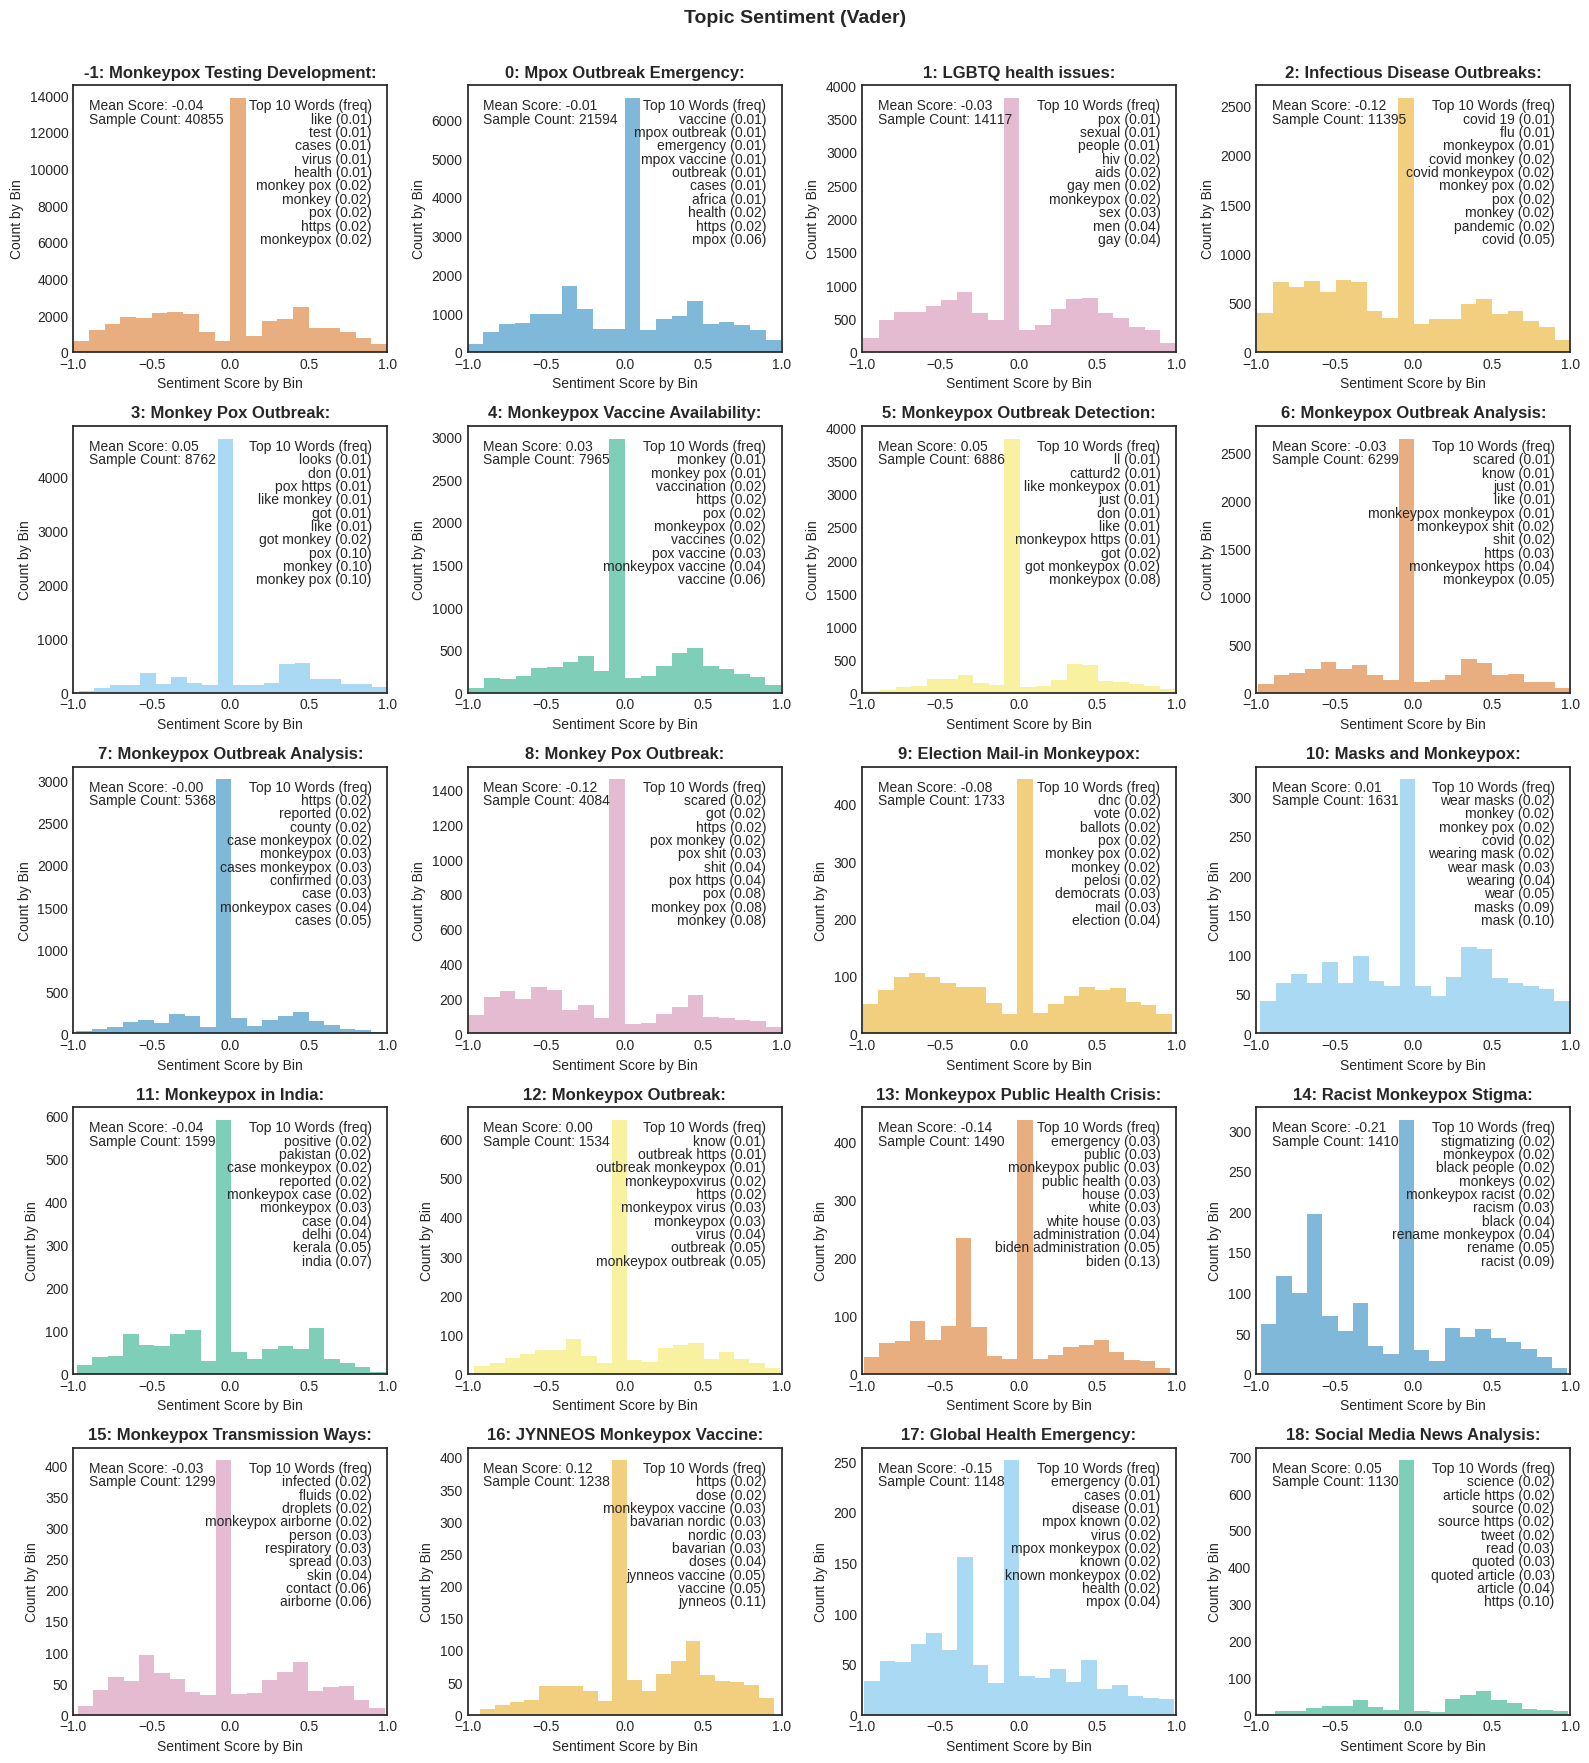

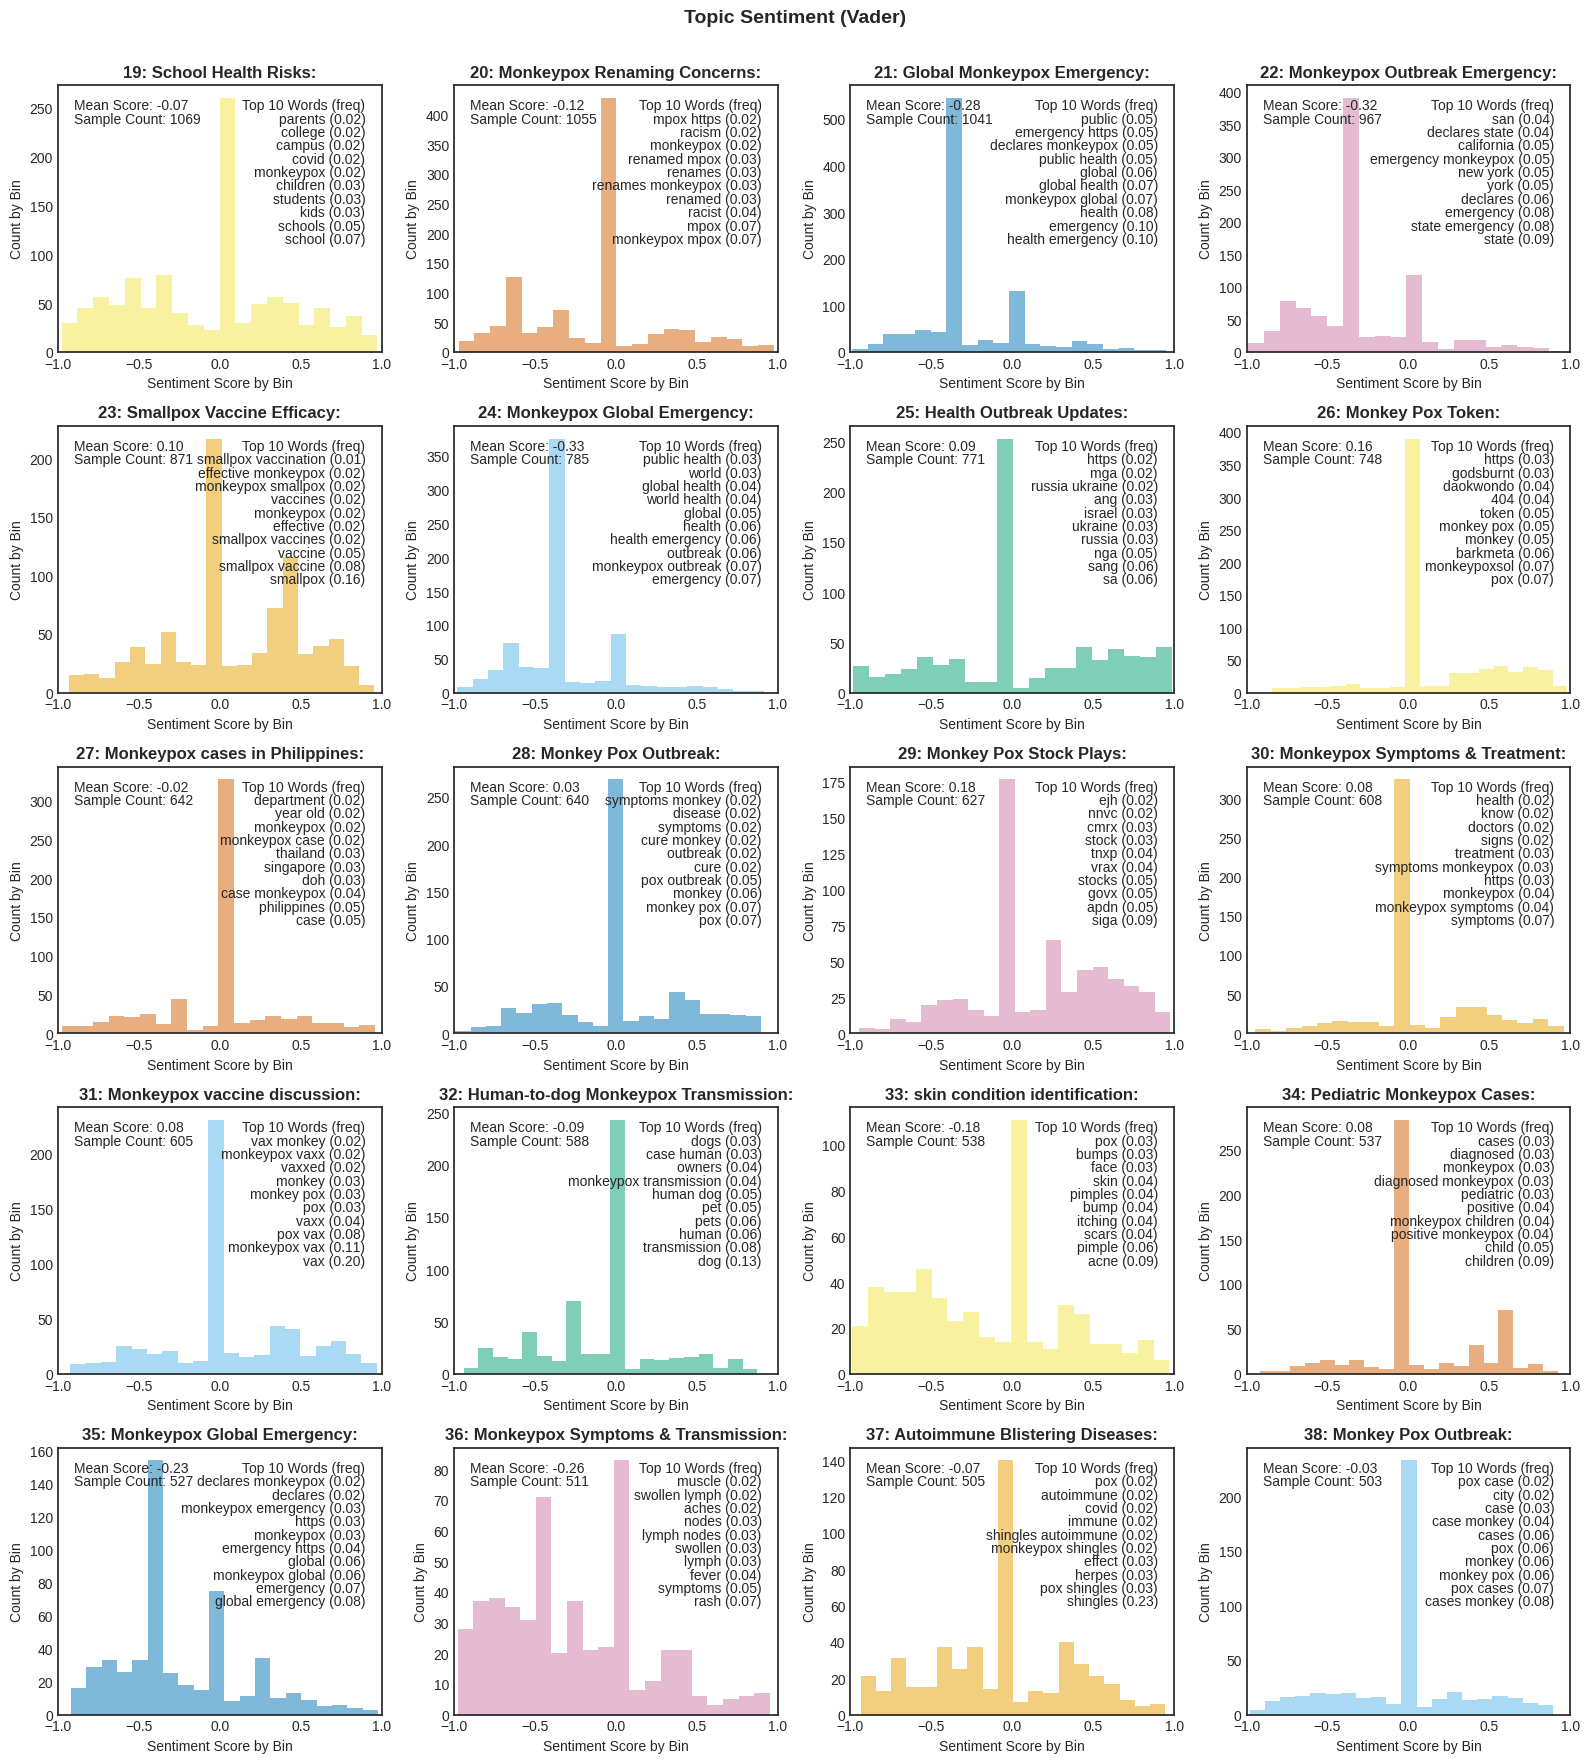

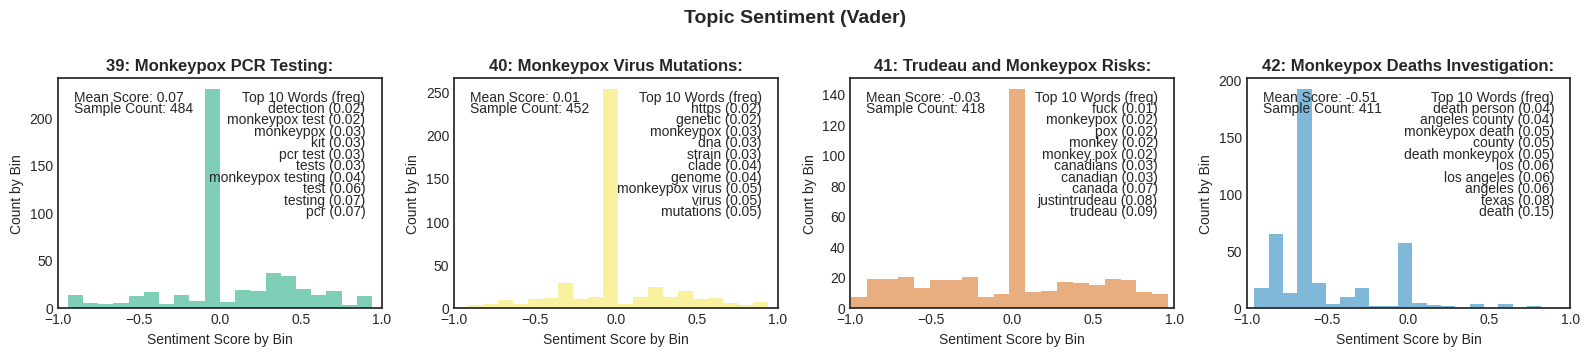

In [33]:
###vader polarity version

def sentiment_by_topic_vader(df, topic_model,topic_range, file_name_appendix, base_path, figures, fig_names):
    """
    Inputs:
    df = Dataframe with:
            - a column labeled "vader_polarity" that contains sentiment scores
            - a column labeled "topic_num" that contains the topic number assigned by the BERTopic model
    topic_model = an instance of a fit BERTopic model
    topic_range = range of topics to plot

    Action: Generates a series of graphs of sentiment for text samples aligned to each topic in batches of 20 subplots.
    """

    def sentiment_sub(df, title, ax, words, color):
        avg = df.vader_polarity.mean()
        ct = len(df)
        ax.hist(df.vader_polarity, bins=20, alpha=0.5, color=color)
        ax.set_title(f"{title}:", fontweight='bold')
        ax.set_xlim(-1, 1)
        ax.annotate(f'Mean Score: {avg:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
        ax.annotate(f'Sample Count: {ct}', xy=(0.05, 0.90), xycoords='axes fraction', ha='left', va='top')
        ax.annotate(f'Top {len(words)} Words (freq)', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
        for z, w in enumerate(words):
            ax.annotate(words[z], xy=(0.95, 0.95 - (z + 1) * .05), xycoords='axes fraction', ha='right', va='top')
        ax.set_xlabel('Sentiment Score by Bin')
        ax.set_ylabel('Count by Bin')

    # Get openAI summaries and topic frequency information
    topic_info_sub = topic_model.get_topic_info()
    open_ai_summaries = dict(zip(topic_info_sub.Topic, topic_info_sub.OpenAI))
    n_words = 10
    n_topics = len(topic_range)
    colors = itertools.cycle(["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"])

    # Loop through topic_range in batches of 20
    for batch_start in range(0, n_topics, 20):
        batch_end = min(batch_start + 20, n_topics)
        batch_range = topic_range[batch_start:batch_end]

        # Set the layout for subplots dynamically based on batch size
        n_topics_batch = len(batch_range)
        n_cols = 4
        n_rows = (n_topics_batch + n_cols - 1) // n_cols  # Compute needed rows dynamically

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3.5 * n_rows))
        ax = axes.flatten()

        for j, topic_id in enumerate(batch_range):
            c = next(colors)
            words = [word + " " + f"({score:.2f})" for word, score in topic_model.get_topic(topic_id)][:n_words][::-1]
            topic_sample = df[df.topic_num == topic_id].reset_index(drop=True)
            title = f'{topic_id}: {open_ai_summaries[topic_id][0]}'
            sentiment_sub(topic_sample, title, ax[j], words, c)

        plt.suptitle('Topic Sentiment (Vader)', fontsize=14, fontweight='bold', y=1.005)
        plt.tight_layout()

        # Save each figure
        count = batch_start // 20 + 1
        fig_name = f'top_words_sentiment_vader_{count}_{file_name_appendix}'
        fig.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/{fig_name}.jpeg'), bbox_inches='tight')
        figures.append(fig)
        fig_names.append(fig_name)

        # Turn off unused axes
        for k in range(n_topics_batch, len(ax)):
            ax[k].axis("off")

    return figures, fig_names

# Define the range of topics you want to plot (e.g., all topics from -1 to the max topic number)
topic_range = np.arange(-1, len(set(topic_info_m['Topic']))-1)

#Use function if VADER is selected
if VADER == True:
  figures, fig_names = sentiment_by_topic_vader(combo_pd, topic_model_m, topic_range, file_name_appendix, base_path, figures, fig_names)
else:
  pass

#### **4e.  Word Clouds for Topics**


Directory '/content/drive/MyDrive/Harvard_colab/Capstone_2025/Code Repositories/data/results/model_X_meta_sample_400_100/figures/wordclouds/' already exists.


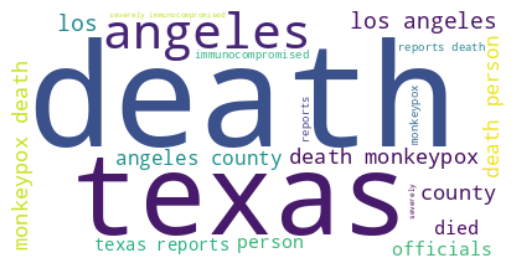

In [34]:
#### Save word clouds individually ####
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Checks to make sure there is a figures directory for the loaded model:
fig_path = os.path.join(base_path,f'results/model_{file_name_appendix}/figures/wordclouds/')
create_directory_if_not_exists(fig_path)

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/wordclouds/wordcloud_topic_{topic}.jpeg'), bbox_inches='tight')

# Show wordcloud
if generate_topic_level == True:
  topic_range = np.arange(-1, len(set(topic_info_m['Topic']))-1)
  for t in topic_range:
    create_wordcloud(topic_model_m, topic=t)

In [35]:
#### Groups Wordclouds in batches corresponding to a Topic Range ####
def wordcloud_multi(topic_model, topic_range, topic_info, file_name_appendix, base_path, figures, fig_names):

    open_ai_summaries = dict(zip(topic_info.Topic, topic_info.AI_Summaries))
    freq_df = topic_model.get_topic_freq()

    # Get counts and set column and row numbers for graphs
    n_words = 10
    n_topics = len(topic_range)
    n_cols = 4
    n_rows = (n_topics + n_cols - 1) // n_cols  # Compute needed rows dynamically

    # Batch topics into groups
    batch_size = 24
    topic_batches = [topic_range[i:i + batch_size] for i in range(0, len(topic_range), batch_size)]

    # Plot each batch separately
    for batch in topic_batches:
        n_topics_batch = len(batch)
        n_rows_batch = (n_topics_batch + n_cols - 1) // n_cols  # Compute rows needed for this batch
        fig, axes = plt.subplots(n_rows_batch, n_cols, figsize=(15, 2.5 * n_rows_batch))
        ax = axes.flatten()

        for j, i in enumerate(batch):

            text = {word: value for word, value in topic_model.get_topic(i)}
            wc = WordCloud(background_color="white", max_words=1000)
            wc.generate_from_frequencies(text)
            ax[j].imshow(wc, interpolation="bilinear")
            ax[j].axis("off")
            ct = int(topic_info_m.Count[i])  # Sample counts for each topic
            title = f'{i}:{open_ai_summaries[i]}\nSample Count: {ct:,}'  # Graph title based on AI Summary
            ax[j].set_title(f"{title}", fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.suptitle('Word Clouds by Topic Area', fontsize=14, fontweight='bold', y=1.005)

        # Turn off unused axes
        for k in range(n_topics_batch, len(ax)):
            ax[k].axis("off")

        plt.show()

        # Save each figure
        fig_name = f'wordcloud_multi_{batch}_{file_name_appendix}'
        fig.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/{fig_name}.jpeg'), bbox_inches='tight')
        figures.append(fig)
        fig_names.append(fig_name)

    return figures, fig_names


topic_range = np.arange(0, len(set(topic_info_m['Topic']))- 1)
# Show wordcloud
figures, fig_names = wordcloud_multi(topic_model_m, topic_range, topic_info_m, file_name_appendix, base_path, figures, fig_names)

Output hidden; open in https://colab.research.google.com to view.

### **5. Topic Overviews**

#### **5a. Topic Summary Visual**

In [36]:
# Checks to make sure there is a figures directory for the loaded model:
fig_path = os.path.join(base_path,f'results/model_{file_name_appendix}/figures/topic_summaries/')
create_directory_if_not_exists(fig_path)
topic_figs = []

#Function for visual
def topic_summary_visual(combo_pd,topic_info_m,topic_num):
  topic_df = combo_pd[combo_pd.topic_num==topic_num].reset_index(drop=True)

  fig, axes = plt.subplots(2, 2, figsize=(11,6))
  ax = axes.flatten()

  #### Sentiment Barchart
  n_words = 10
  open_ai_summaries = dict(zip(topic_info_m.Topic, topic_info_m.AI_Summaries))

  words = [word + " " + f"({score:.2f})" for word, score in topic_model_m.get_topic(topic_num)][:n_words][::-1]
  title = f'VADER Sentiment and Top 10 cTF-IDF Words'
  avg = topic_df.vader_polarity.mean()
  ct = len(topic_df)
  ax[0].hist(topic_df.vader_polarity, bins=20, alpha=0.5)
  ax[0].set_title(f"{title}:", fontweight='bold',fontsize=11)
  ax[0].set_xlim(-1, 1)
  ax[0].annotate(f'Mean Sentiment\nScore: {avg:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
  ax[0].annotate(f'Top {len(words)} Words(cTF-IDF result):', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top', fontweight='bold')
  for z, w in enumerate(words):
    ax[0].annotate(words[z], xy=(0.95, 0.95 - (z + 1) * .06), xycoords='axes fraction', ha='right', va='top')
  ax[0].set_xlabel('Sentiment Score by Bin')
  ax[0].set_ylabel('Count of Samples by Bin')

  ### Word Cloud ####
  text = {word: value for word, value in topic_model_m.get_topic(topic_num)}
  wc = WordCloud(background_color="white", max_words=1000)
  wc.generate_from_frequencies(text)
  ax[1].imshow(wc, interpolation="bilinear")
  ax[1].axis("off")
  ax[1].set_title(f"Key Word Cloud:", fontsize=11, fontweight='bold')

  #### Topics Over Time ####
  #plot grey lines for all topics as comparison
  topic_range = np.arange(0,len(topic_info_m.Topic)-1,1)
  for t in topic_range:
    sample = topics_over_time[topics_over_time.Topic == t]
    ax[2].plot(sample.Timestamp,sample.Frequency,c='grey',alpha=0.3)

  #plot blue line for topic in focus
  sample = topics_over_time[topics_over_time.Topic == topic_num]
  ax[2].plot(sample.Timestamp,sample.Frequency,c='blue',label = f'Topic:{topic_num}')
  ax[2].legend()

  #Add keywords by year as annotation to plot
  topic_by_yr = topics_by_analysis_yr[topics_by_analysis_yr.Topic == topic_num]
  topic_by_yr['analysis_year'] = topic_by_yr['Timestamp'].dt.year
  ax[2].annotate(f'Key Words by Year:', xy=(0.3, 0.95), xycoords='axes fraction', ha='left', va='top', fontweight='bold')

  years = [2022, 2023, 2024]
  for z,y in enumerate(years):
    # Check if there is data for the year
    if not topic_by_yr[topic_by_yr.analysis_year == y].empty:
        year = int(topic_by_yr[topic_by_yr.analysis_year == y].analysis_year.iloc[0])
        words = topic_by_yr[topic_by_yr.analysis_year == y].Words.to_list()[0]
        ax[2].annotate(f'{year}: {words}',
                       xy=(0.15, 0.95 - (z + 1) * .07),
                       xycoords='axes fraction',
                       ha='left', va='top')
    else:
        # If no data for that year, do not annotate or display a message
        ax[2].annotate(f'{y}: No Data Available',
                       xy=(0.3, 0.95 - (z + 1) * .07),
                       xycoords='axes fraction',
                       ha='left', va='top', color='red')


  #Titles and lables
  ax[2].set_title(f'Topics Over Time:',fontsize=11,fontweight = 'bold')
  ax[2].set_ylabel('Count of Samples')
  ax[2].tick_params(axis='x', labelsize=8)

  #### User Enagement and Sentiment ####
  if engagement == 'meta':
    sent_measures = ['statistics.angry_count','statistics.care_count','statistics.haha_count',
                          'statistics.like_count','statistics.love_count','statistics.sad_count',
                          'analysis_year']
    views = topic_df['statistics.views'].sum()
    reactions = topic_df['statistics.reaction_count'].sum()
    comments = topic_df['statistics.comment_count'].sum()
    shares = topic_df['statistics.share_count'].sum()

    # Calculate total reactions for each sentiment type and year
    topic_sent_df = topic_df[sent_measures]
    topic_sent_df.columns = ['angry','care','haha','like','love','sad','analysis_year']
    topic_sent_pivot = topic_sent_df.pivot_table(index = 'analysis_year',aggfunc='sum')
    topic_sent_pivot = topic_sent_pivot.loc[:,topic_sent_pivot.sum().sort_values(ascending=False).index].T

    # Calculate percentage of total reactions for each sentiment type and year
    percentage_sentiment_pivot = topic_sent_pivot / reactions * 100
    percentage_sentiment_pivot = percentage_sentiment_pivot.T.sum()

  elif engagement == 'aggregated':
    sent_measures = ['Master Shares','Master Replies', 'Master Likes or negative reactions','analysis_year']
    views = topic_df['Master Views'].sum()
    topic_sent_df = topic_df[sent_measures]
    topic_sent_df.columns = ['shares','replies','likes or neg reactions','analysis_year']
    topic_sent_pivot = topic_sent_df.pivot_table(index = 'analysis_year',aggfunc='sum')
    topic_sent_pivot = topic_sent_pivot.loc[:,topic_sent_pivot.sum().sort_values(ascending=False).index].T

    percentage_sentiment_pivot = topic_sent_pivot / views * 100
    percentage_sentiment_pivot = percentage_sentiment_pivot.T.sum()

  else:
    pass


  years = [2022, 2023, 2024]

  if (engagement == 'meta') or (engagement == 'aggregated'):
    # Create a twin axis for percentage plot
    ax2 = ax[3].twinx()
    bottoms = [0] * len(topic_sent_pivot.index)
    # Plotting the sentiment bar chart
    for year in years:
      if not topic_by_yr[topic_by_yr.analysis_year == year].empty:
        ax[3].bar(topic_sent_pivot.index, topic_sent_pivot[year], bottom=bottoms, alpha=0.5, label=str(year))
        bottoms = [bottom + height for bottom, height in zip(bottoms, topic_sent_pivot[year])]
      else:
        pass
    # Plotting secondary axis for percent of totals
    ax2.plot(percentage_sentiment_pivot.index, percentage_sentiment_pivot.values, label='Percent of Total',
    marker='o', alpha=0.7, color='black', linestyle='--')
    # Annotate each point with its percentage value
    for i, value in enumerate(percentage_sentiment_pivot.values):
            ax2.annotate(f'{value:.1f}%',  # Format the percentage value with one decimal place
                         (percentage_sentiment_pivot.index[i], value),  # Position of the annotation
                         textcoords="offset points",  # To position the text
                         xytext=(10, 10),  # Offset by 10 points vertically
                         ha='left',
                         va='center',# Center the annotation horizontally
                         color='black',  # Set annotation color to match the plot line
                         fontsize=8)  # Smaller font size for clarity

    # Adding labels and title
    ax[3].annotate(f'General Engagement:', xy=(0.95, 0.48), xycoords='axes fraction', ha='right', va='bottom',fontweight='bold')
    ax[3].annotate(f'Total Views: {int(views):,}', xy=(0.95, 0.41), xycoords='axes fraction', ha='right', va='bottom')
    if engagement == 'meta':
      ax[3].annotate(f'Total Reactions: {int(reactions):,}', xy=(0.95, 0.34), xycoords='axes fraction', ha='right', va='bottom')
      ax[3].annotate(f'Total Comments: {int(comments):,}', xy=(0.95, 0.27), xycoords='axes fraction', ha='right', va='bottom')
      ax[3].annotate(f'Total Shares: {int(shares):,}', xy=(0.95, 0.20), xycoords='axes fraction', ha='right', va='bottom')

    ax2.set_ylim(0,100)
    ax2.set_ylabel('Percent of Total')
    ax[3].set_xlabel('Sentiment Type')
    ax[3].set_ylabel('Count of Samples')
    ax[3].set_title('Post Sentiment by Year', fontsize=11, fontweight='bold')
    ax[3].legend()

  else:
    ax[3].axis('off')

  plt.tight_layout()
  title = f'Topic {topic_num}: {open_ai_summaries[topic_num]}         Sample Count: {ct:,}'  # Graph title based on AI Summary
  plt.suptitle(title, fontweight='bold', y=1.02)
  #plt.show()

  return fig

Directory '/content/drive/MyDrive/Harvard_colab/Capstone_2025/Code Repositories/data/results/model_X_meta_sample_400_100/figures/topic_summaries/' already exists.


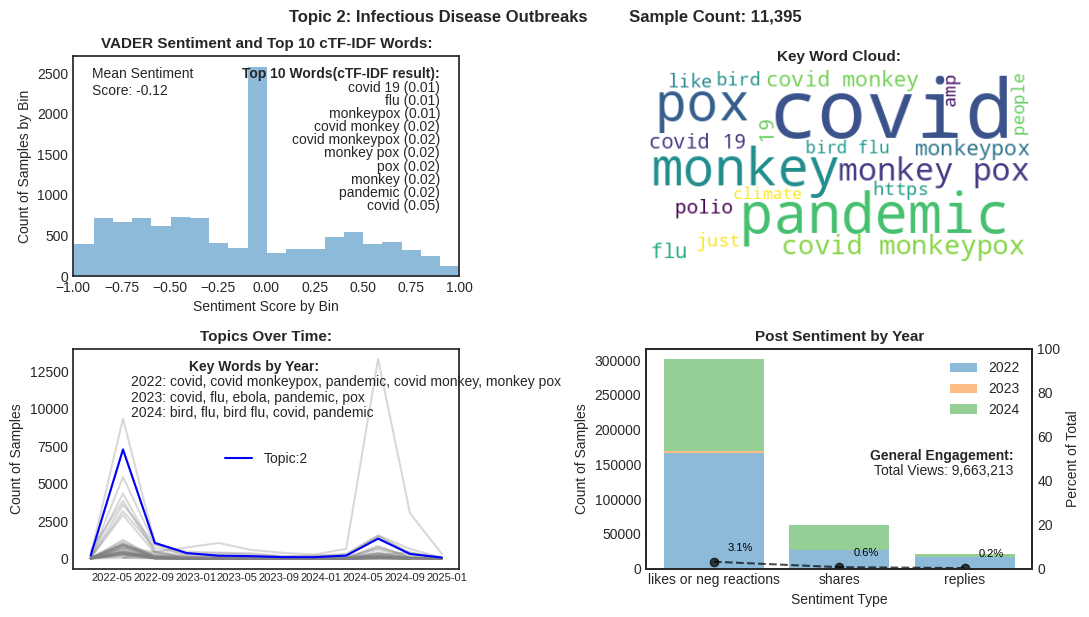

In [37]:
#Display one topic
topic_num=2
fig = topic_summary_visual(combo_pd,topic_info_m,topic_num)
fig.show()

In [38]:
# Generate full set of topic figures and save to folder/add to pdf report
if generate_topic_level == True:
  topic_range = np.arange(-1, len(set(topic_info_m['Topic']))-1)
  for topic_num in topic_range:
    fig = topic_summary_visual(combo_pd,topic_info_m,topic_num)
    fig.savefig(os.path.join(base_path, f'results/model_{file_name_appendix}/figures/topic_summaries/summary_{topic_num}.jpeg'), bbox_inches='tight')
    topic_figs.append(fig)

Output hidden; open in https://colab.research.google.com to view.

#### **5b. Topic Text Outputs**

**Top_10_Most_Viewed, By Source**

In [39]:
### Generate the Top 10 most viewed posts ####
topic_range = np.arange(0, len(set(topic_info_m['Topic']))-1,1)
sources = combo_pd.master_source.unique()

if engagement == 'meta':
  for topic_num in topic_range:
    if topic_num == 0:
      top_ten_most_viewed = combo_pd[combo_pd.topic_num==topic_num].sort_values(by='statistics.views',
            ascending=False).head(10).loc[:,['master_source','topic_num','text','statistics.views','date']]
    else:
      next = combo_pd[combo_pd.topic_num==topic_num].sort_values(by='statistics.views',
            ascending=False).head(10).loc[:,['master_source','topic_num','text','statistics.views','date']]
      top_ten_most_viewed = pd.concat([top_ten_most_viewed,next], axis=0)
  #Output to CSV
  top_ten_most_viewed.to_csv(os.path.join(base_path,
          f'results/model_{file_name_appendix}/figures/top_ten_most_viewed_{file_name_appendix}.csv'),
          encoding = 'utf-8-sig',index=False)
elif engagement == 'aggregated':
  for topic_num in topic_range:
    if topic_num == 0:
      top_ten_most_viewed = combo_pd[combo_pd.topic_num==topic_num].sort_values(by='Master Views',
      ascending=False).head(10).loc[:,['master_source','topic_num','text','Master Views','date']]
    else:
      next = combo_pd[combo_pd.topic_num==topic_num].sort_values(by='Master Views',ascending=False).head(10).loc[:,['master_source','topic_num','text','Master Views','date']]
      top_ten_most_viewed = pd.concat([top_ten_most_viewed,next], axis=0)
  # Output to CSV
  top_ten_most_viewed.to_csv(os.path.join(base_path,
          f'results/model_{file_name_appendix}/figures/top_ten_most_viewed_{file_name_appendix}.csv'),
          encoding = 'utf-8-sig',index=False)
else:
  pass

**Viewed by Source**

In [1]:
### Generate the Top 10 most viewed posts by Data Source ####
topic_range = np.arange(0, len(set(topic_info_m['Topic']))-1,1)
sources = combo_pd.master_source.unique()

if engagement == 'aggregated':
  for topic_num in topic_range:
    for source in sources:
      if topic_num == 0:
        top_ten_most_viewed = combo_pd[(combo_pd.topic_num==topic_num) & (combo_pd.master_source == source)].sort_values(by='Master Views',
        ascending=False).head(10).loc[:,['master_source','topic_num','text','Master Views','date']]
      else:
        next = combo_pd[(combo_pd.topic_num==topic_num) & (combo_pd.master_source == source)].sort_values(by='Master Views',ascending=False).head(10).loc[:,['master_source','topic_num','text','Master Views','date']]
        top_ten_most_viewed = pd.concat([top_ten_most_viewed,next], axis=0)
  # Output to CSV
  top_ten_most_viewed.to_csv(os.path.join(base_path,
          f'results/model_{file_name_appendix}/figures/top_ten_most_viewed_by_source_{file_name_appendix}.csv'),
          encoding = 'utf-8-sig',index=False)
else:
  pass

NameError: name 'np' is not defined

In [ ]:
top_ten_most_viewed

**Source-Specific Summaries:**

In [41]:
"""
if sources > 1:
  for topic_num in topic_range:
    for source in sources:
   """


'\nif sources > 1:\n  for topic_num in topic_range:\n    for source in sources:\n   '

**Text Samples from Quartiles for Each Topic (for Validation)**

In [42]:
for j in topic_range:
    # Assuming combo_pd is your original dataframe, and j is the specific topic number you're working with
    topic_probs = combo_pd[combo_pd.topic_num == j].sort_values(by='top_prob', ascending=False).loc[:, ['text', 'topic_num', 'top_prob']]

    # Initialize lists to hold samples
    sample_1, sample_2, sample_3 = None, None, None

    # Sample 5 rows from each probability range, or fewer if there are not enough rows
    if not topic_probs[(topic_probs['top_prob'] >= 0.76) & (topic_probs['top_prob'] <= 1)].empty:
        sample_1 = topic_probs[(topic_probs['top_prob'] >= 0.76) & (topic_probs['top_prob'] <= 1)].sample(n=min(5, len(topic_probs[(topic_probs['top_prob'] >= 0.76) & (topic_probs['top_prob'] <= 1)])), random_state=42)
        sample_1 = ' || '.join(sample_1.text.to_list())
        sample_1 = pd.DataFrame({'topic_num': [f'{j}'], 'label': ['Top: 0.76 to 1'], 'text_samples': sample_1})

    if not topic_probs[(topic_probs['top_prob'] >= 0.51) & (topic_probs['top_prob'] < 0.76)].empty:
        sample_2 = topic_probs[(topic_probs['top_prob'] >= 0.51) & (topic_probs['top_prob'] < 0.76)].sample(n=min(5, len(topic_probs[(topic_probs['top_prob'] >= 0.51) & (topic_probs['top_prob'] < 0.76)])), random_state=42)
        sample_2 = ' || '.join(sample_2.text.to_list())
        sample_2 = pd.DataFrame({'topic_num': [f'{j}'], 'label': ['Mid: 0.51 to 0.75'], 'text_samples': sample_2})

    if not topic_probs[(topic_probs['top_prob'] >= 0.26) & (topic_probs['top_prob'] < 0.51)].empty:
        sample_3 = topic_probs[(topic_probs['top_prob'] >= 0.26) & (topic_probs['top_prob'] < 0.51)].sample(n=min(5, len(topic_probs[(topic_probs['top_prob'] >= 0.26) & (topic_probs['top_prob'] < 0.51)])), random_state=42)
        sample_3 = ' || '.join(sample_3.text.to_list())
        sample_3 = pd.DataFrame({'topic_num': [f'{j}'], 'label': ['Low: 0.26 to 0.50'], 'text_samples': sample_3})

    # Concatenate the samples if they are not None
    samples = []
    if sample_1 is not None:
        samples.append(sample_1)
    if sample_2 is not None:
        samples.append(sample_2)
    if sample_3 is not None:
        samples.append(sample_3)

    # Concatenate the samples
    if samples:
        sample = pd.concat(samples, ignore_index=True)

        if 'final_sample' in locals():
            final_sample = pd.concat([final_sample, sample], ignore_index=True)
        else:
            final_sample = sample

# Reset the index if needed
final_sample = final_sample.reset_index(drop=True)
final_sample.to_csv(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/samples_by_prob_{file_name_appendix}.csv'),encoding = 'utf-8-sig',
    index=False  )

# View the final sampled dataframe
display(final_sample)

topic_num              label  \
0           0     Top: 0.76 to 1   
1           0  Mid: 0.51 to 0.75   
2           0  Low: 0.26 to 0.50   
3           1     Top: 0.76 to 1   
4           1  Mid: 0.51 to 0.75   
..        ...                ...   
123        41     Top: 0.76 to 1   
124        41  Mid: 0.51 to 0.75   
125        41  Low: 0.26 to 0.50   
126        42     Top: 0.76 to 1   
127        42  Mid: 0.51 to 0.75   

                                          text_samples  
0    Mpox is not the new COVID says WHO official ht...  
1    This is the opportunity you’ve been looking fo...  
2    #Breaking:  World Health Organization has decl...  
3    MONKEYPOX | As monkeypox cases rise, health of...  
4    With monkeypox spreading from intimacy a lot o...  
..                                                 ...  
123  @Concern70732755 He is corrupt narcissistic an...  
124  Manitoba to provide monkeypox update Friday – ...  
125  Canada to introduce mandatory monkeypox quaran...  
126  Death of person with monkeypox in Los Angeles ...  
127  No deaths from monkeypox were reported by the ...  

[128 rows x 3 columns]

**Topic AI Summaries and Negative Sentiment Posts**

In [43]:
#For each Topic, extract the top, most representative samples overall, and for negative sentiment samples. Provide OpenAI summaries of the documents:
topic_num = 2
top_posts_num = 100

top_posts = combo_pd[combo_pd.topic_num==topic_num].sort_values(by='top_prob', ascending = False)[:top_posts_num].text.to_list()
print(f"{topic_info_m[topic_info_m.Topic==topic_num].AI_Summaries.to_list()[0]}")

print(f"Top_text_samples:")
top_posts


Infectious Disease Outbreaks
Top_text_samples:


['Monkeypox: Evidence Of The Pandemic Preparedness Liehttps://t.co/2Da9gpXjG7$AAPL $ABBV $ADBE $AMAT $AMT $AMZN $BABA $DIS $DISH $ELY $FDX $GOOG $HD $INTC $IWM $JPM $LK $LOW $LULU $LYFT $NVDA $NFLX $PINS $QQQ $RH $ROKU $SNAP $SPY $TLT $T $TSLA $TVIX $UWT $UVXY $V $VXX $XOM https://t.co/aAoajOSKWy',
 '@Sarah_Katilyn Probably just COVID… lol … no worries as MonkeyPox is the current thing 😂😂😂',
 "@webbbieone Great now he'll get the Covid AND monkey pox...",
 "Here are some of the afternoon's Top Stories: Covid numbers surge in New York Monkeypox cases continue to rise and mobile sports betting revenue exceeds expectations. https://t.co/rTSZnlgWxm",
 'We are now at the Diamond Princess phase of the monkeypox pandemic. https://t.co/W1BTOTgA02',
 'When covid ain’t work they send out monkey pox',
 '@MucciFlipFlop *gets monkeypox* “oMG I hope that’s not Covid”',
 'I just know I don’t want to take the chance of COVID or monkey pox on a plane 😕',
 '@YourBudTevin You mean get Covid AND monkey pox

In [44]:
prompt = f"Summarize this content in 100 words or less {top_posts}"
prompt_result = query_gpt_3_5(prompt)
prompt_result

'The content discusses the emergence of monkeypox as another potential pandemic after COVID-19. People express various reactions to the rise in monkeypox cases and question the seriousness of this new threat compared to COVID-19. Some are worried about the impact of multiple pandemics, while others downplay the significance of monkeypox. Conspiracy theories and skepticism about public health narratives are also present. Overall, the content reflects how society is grappling with the uncertainty and implications of another infectious disease outbreak.'

**Negative Sentiment**

In [45]:
top_posts_num = 10
negative_sentiment = combo_pd[combo_pd.topic_num==topic_num].sort_values(by='vader_polarity', ascending = False)[:top_posts_num].text.to_list()

print(topic_info_m[topic_info_m.Topic==topic_num].OpenAI)

print(f"negative_sentiment:")
prompt = f"Summarize this content in 100 words or less {negative_sentiment}"
prompt_result = query_gpt_3_5(prompt)
prompt_result

3    [Infectious Disease Outbreaks]
Name: OpenAI, dtype: object
negative_sentiment:


"Monkey pox and Covid infections were previously not believed to occur simultaneously, but recent reports suggest otherwise. Social media users have been making jokes about the situation, but some individuals are warning about potential challenges ahead. Rising gas prices, food shortages, a new potential wave of COVID-19, and the emergence of monkeypox cases are causing concern. There are also discussions about a pandemic treaty that could increase the WHO's authority over international pandemic responses. In light of these challenges, individuals are advised to prepare by getting organized with their communities, stocking up on food, and being proactive in their approach."

In [46]:
negative_sentiment

['previously it was not believed that monkey pox and covid infections can happen simultaneously... 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣 https://t.co/fBAGY5Wk1w',
 "@BidensWins 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣13 dead troops in Afghanistan600K more dead from covid9.1% inflationHe's celebrating $4.20 gasSupply chain disruptionsMonkey poxIf this were happening under Trump then you'd see actual negative media coverage",
 "@Tim_Walz Cough cough cough no I can't Timmy I got covid and monkey pox....🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣",
 'https://t.co/9ZeSuqhhHy 🤣🤣🤣🤣🤣🤣🤣🤣🤣 here we go again  the who said m-pox aint the new covid  now this 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣👇👇👇👇👇👇👇👇👇👇👇👇👇👇',
 '@robreiner 😂😂😂😂 💔💔💔💔💔💔 higher food prices 💔💔💔💔💔higher gas prices 💔💔💔💔💔💔higher Covid deaths 💔💔💔💔💔Monkey pox💔💔💔💔💔💔💔💔Afghanistan débâcle 💔💔💔💔lowest approval ratings in history. Should I continue !!!!!💔💔💔💔TDS lives on…. 💔💔💔💔',
 "AAA OFFERS FREE 'TOW AND GO' \nFor many, driving is not only the most economical way to travel but 

### **6. Sample KPIs: Topic, by Source and Language**

**Source**

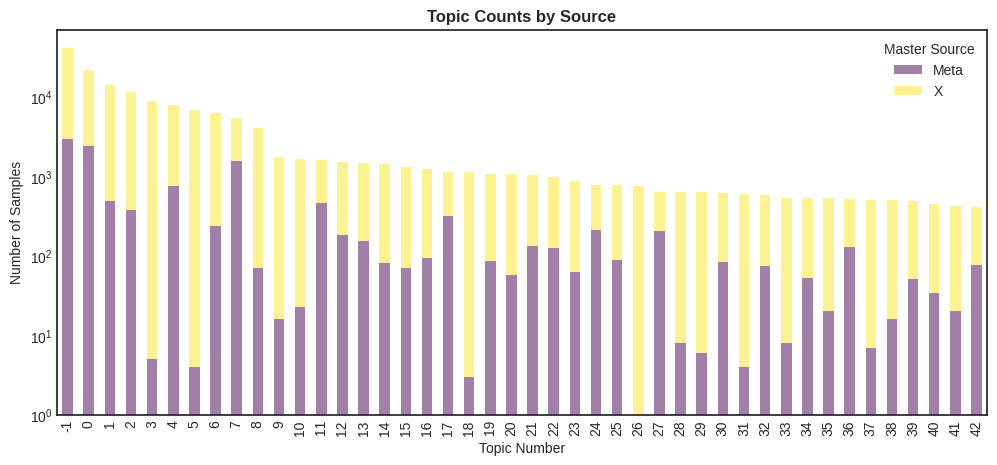

In [47]:
#### SOURCE PLOT #####
source_topic_cts = combo_pd.pivot_table(index = 'topic_num',values='text',columns='master_source', aggfunc=len)

# Set figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the pivot table as a stacked bar chart
source_topic_cts.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', alpha=0.50)

# Customize the plot
ax.set_title("Topic Counts by Source", fontweight='bold')
ax.set_xlabel("Topic Number")
ax.set_ylabel("Number of Samples")
ax.legend(title="Master Source")
ax.tick_params(axis='x', rotation=90)  # Keeps topic numbers readable
ax.set_yscale('log');

# Show the plot
plt.show()

#exports to jpeg and for pdf in section 7
fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/samples_source_topic_{file_name_appendix}.jpeg'),bbox_inches='tight')
figures.append(fig)
fig_names.append('samples_source_topic_{file_name_appendix}')

**Language**

In [48]:
#Caculate splits of samples allocated to each topic and in each of the top 10 langauges
lang_topic_cts = combo_pd.pivot_table(index = 'topic_num',values='text',columns='lang', aggfunc=len)

totals = []
for x in lang_topic_cts.columns:
    totals.append(np.sum(lang_topic_cts.loc[:,x]))

df = pd.DataFrame({'lang':lang_topic_cts.columns,'ct':totals}).sort_values('ct',ascending=False)

#Filter data for top 10 languages"
top_10 = df.iloc[:10,:]
top_10_list = top_10.lang.to_list()
top_10_lang_topic = lang_topic_cts.loc[:,top_10_list]

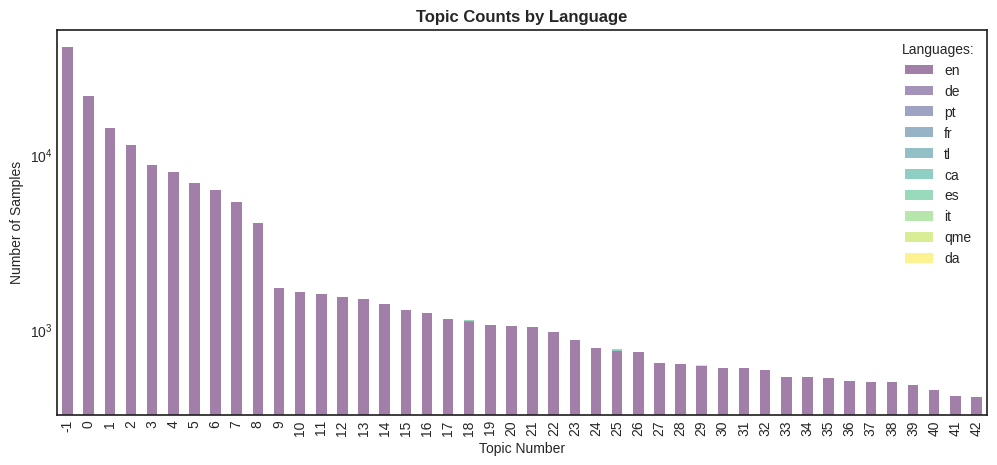

In [49]:
#### Language PLOT #####
# Set figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the pivot table as a stacked bar chart
top_10_lang_topic.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', alpha=0.50)

# Customize the plot
ax.set_title("Topic Counts by Language", fontweight='bold')
ax.set_xlabel("Topic Number")
ax.set_ylabel("Number of Samples")
ax.legend(title="Languages:")
ax.tick_params(axis='x', rotation=90)  # Keeps topic numbers readable
ax.set_yscale('log')

# Show the plot
plt.show()

#exports to jpeg and for pdf in section 7
fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/samples_language_topic_{file_name_appendix}.jpeg'),bbox_inches='tight')
figures.append(fig)
fig_names.append('samples_language_topic_{file_name_appendix}')

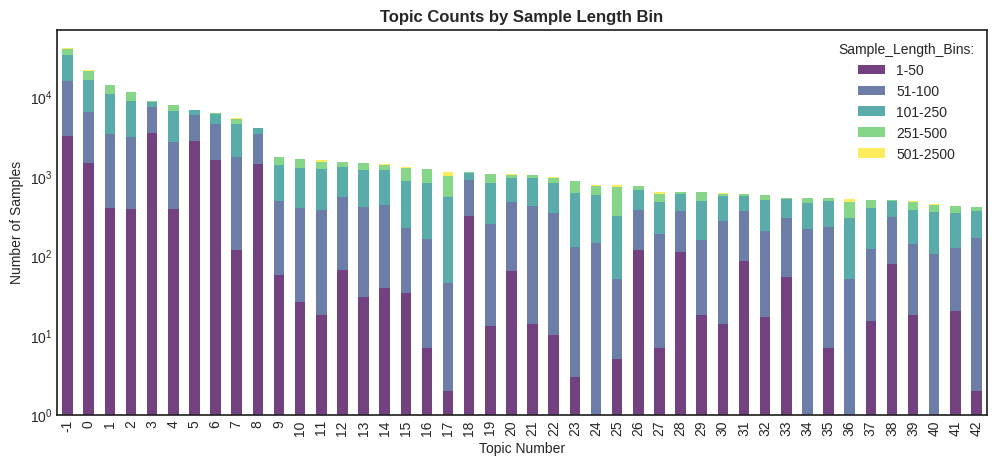

In [50]:
#### TEXT LENGTH PLOT #####

#### PREP
# Sample DataFrame
combo_pd['char_length'] = [len(str(sample)) for sample in combo_pd['text']]

# Define bins and labels
bins = [0, 50, 100, 250, 500, 2500, float('inf')]
labels = ['1-50', '51-100', '101-250', '251-500', '501-2500', '2500+']

# Categorize values into groups
combo_pd['length_bins'] = pd.cut(combo_pd['char_length'], bins=bins, labels=labels, right=True)

length_topic_cts = combo_pd.pivot_table(index = 'topic_num',values='text',columns='length_bins', aggfunc=len)

totals = []
for x in length_topic_cts.columns:
    totals.append(np.sum(length_topic_cts.loc[:,x]))

df = pd.DataFrame({'length':length_topic_cts.columns,'ct':totals}).sort_values('ct',ascending=False)

#### PLOT
# Set figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the pivot table as a stacked bar chart
length_topic_cts.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', alpha=0.750)

# Customize the plot
ax.set_title("Topic Counts by Sample Length Bin", fontweight='bold')
ax.set_xlabel("Topic Number")
ax.set_ylabel("Number of Samples")
ax.legend(title="Sample_Length_Bins:")
ax.tick_params(axis='x', rotation=90)  # Keeps topic numbers readable
ax.set_yscale('log')

# Show the plot
plt.show()

#exports to jpeg and for pdf in section 7
fig.savefig(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/samples_length_topic_{file_name_appendix}.jpeg'),bbox_inches='tight')
figures.append(fig)
fig_names.append('samples_length_topic_{file_name_appendix}')

### **7. Pdf and Text Outputs**

**Pdf Report of Images**

In [51]:
#Create a report of all the images above
#https://stackoverflow.com/questions/17788685/python-saving-multiple-figures-into-one-pdf-file

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/rpt_{file_name_appendix}.pdf')) as pdf:
    for f in figures:
        pdf.savefig(f, bbox_inches='tight')
    for f in topic_figs:
        pdf.savefig(f, bbox_inches='tight')


**Tablular Reporting: List of Topics and Counts**

In [52]:
report_df = topic_info_m.loc[:, ['Topic', 'Count', 'AI_Summaries']]
report_df['Count'] = report_df['Count'].apply(lambda x: f"{int(x):,}")
report_df.index = report_df.Topic
report_df.columns = ['Topic Number', 'Sample Count', 'Topic Name']
report_df = report_df.drop(columns='Topic Number')

report_df.style

# Output to CSV
report_df.to_csv(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/topic_list_{file_name_appendix}.csv'))

#Style the output for better readability
styled_df = report_df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},  # Center align headers
    {'selector': 'td:nth-child(3), td:nth-child(4), td:nth-child(5),td:nth-child(6),td:nth-child(7)', 'props': [('text-align', 'left')]}  # Left justify AI_Summaries, words, KeyBERT
])

styled_df

**Tabular Reporting: Topic Summary Information: Appendix**

In [53]:
#Generate a Summary Report for Information About Each Topic
report_df1 = topic_info_m.loc[:, ['Topic', 'Count', 'AI_Summaries', 'words', 'MMR','KeyBERT', 'top_post_summary']]
report_df1['Count'] = report_df1['Count'].apply(lambda x: f"{int(x):,}")

report_df1.index = report_df1.Topic
report_df1.columns = ['Topic Number', 'Sample Count', 'Topic Name', 'Top Ten Words (TF-IDF)','KeyBERT Key Words', 'MMR Key Words' ,'Top Post Summary']
report_df1 = report_df1.drop(columns='Topic Number')

# Output to CSV
report_df1.to_csv(os.path.join(base_path,f'results/model_{file_name_appendix}/figures/topic_summary_{file_name_appendix}.csv'))

#Style the output for better readability
styled_df = report_df1.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},  # Center align headers
    {'selector': 'td:nth-child(3), td:nth-child(4), td:nth-child(5),td:nth-child(6),td:nth-child(7)', 'props': [('text-align', 'left')]}  # Left justify AI_Summaries, words, KeyBERT
])

# Display styled df
styled_df


**Text File: Output of Key Text Samples that Align to Topic**

In [54]:
text_path = os.path.join(base_path,f'results/model_{file_name_appendix}/figures/topic_text_samples_{file_name_appendix}.txt')
# Write the summaries to a text file

with open(text_path, "w", encoding="utf-8") as file:
    for top in topic_info_m.Topic:
        file.write(f'Topic: {top}\n')
        file.write(topic_info_m.loc[topic_info_m.Topic==top,'AI_Summaries'].values[0].replace('\n',' ') + '\n')
        file.write('Top Post Summary\n')
        file.write(topic_info_m.loc[topic_info_m.Topic==top,'top_post_summary'].values[0] + '\n')
        file.write('Top Samples\n')
        file.write(str(topic_info_m.loc[topic_info_m.Topic==top,'top_samples'].values[0]) + '\n')
        try:
          file.write('Negative Summary\n')
          file.write(topic_info_m.loc[topic_info_m.Topic==top,'negative_summary'].values[0] + '\n')
        except:
            pass
        file.write('Negative Samples\n')
        file.write(str(topic_info_m.loc[topic_info_m.Topic==top,'negative_samples'].values[0]) + '\n')
        file.write('--------------------------------------\n')

print("Samples outputted to text file")

Samples outputted to text file
